<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RecSys/blob/main/Alesya%20Moroz/Profpatolog_final(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание задачи

Цель проекта:
Разработать прототип системы, реализующей функцию рекомендательной системы для врача профпатолога.

Принцип работы:
Система должна помогать врачу вынести решение о том годен, не годен или ограниченно годен человек на определенной должности.
В датасете целевым столбцом для предсказания нейросетью является столбец под названием: “ЗаключениеМК”.

## План проекта


1.   EDA (разведывательный анализ данных)
2.   Парсинг данных
3.   Разработка нейросети





---



# 01_Загрузка библиотек

In [ ]:
# %pip install tf-nightly

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential, Model # Полносвязная модель
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями
from tensorflow.keras.metrics import Recall, Precision #,F1Score
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.layers import TextVectorization

import matplotlib.pyplot as plt
import re
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from pandas.core.common import flatten

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import seaborn as sns
import random

from pandas.core.indexes.datetimes import date
from math import nan

# import autokeras as ak

In [ ]:
from google.colab import drive # Подключаем диск
drive.mount('/content/drive')

Mounted at /content/drive


# 02_Работа с нормативной документацией. Формирование справочников
Для универсальности используем токенайзер, во избежание переписывания функций при изменении входных данных (например добавлении или удалении каких-либо параметров)

## 02.1 Функции

In [ ]:
#@title функция для перевода значений/диапазонов МКБ в список

def mkb_to_sequence(arg, values_list):
    lst = []
    new = re.split(r',', arg)
    for i in range(len(new)):
            w = re.sub(r' ','', new[i]).split('-')
            lst.append(w)

    sequence_lst = []
    for i in range(len(lst)):
        value = lst[i]
        index_lst = []

        for j in value:
            index = values_list.index(j)
            index_lst.append(index)

        if len(index_lst) > 1:
            sequence = values_list[index_lst[0]:index_lst[1]+1]
            value = sequence[-1]
            index = values_list.index(value)
        else:
            sequence = value

        i = 1
        while values_list[index+i][2] == values_list[index][2]:
            sequence.append(values_list[index+i])
            i += 1

        sequence_lst.extend(sequence)

    return sequence_lst

In [ ]:
#@title функция для перевода значений/диапазонов вредных факторов в список
def hfactor_to_sequence(arg, values_list):

    factor_lst = []
    new = re.split(r',', arg) # входящую строку разделим по запятым - получим список со значениями/дипазонами
    # print('Значения: (', arg, ')')

    # проходим по списку, удаляем  nan и формируем вложенные списки со значениями или границами диапазонов
    for i in range(len(new)):
            if re.search(r'[^\W\d]', new[i]) == None:   # исключаем наличие буквенных символов во вредных факторах в т.ч 'nan'
                w = re.sub(r' ','', new[i]).split('-')  # убираем пробелы и разделяем диапазон по '-'
                factor_lst.append(w)                    # формируем вложенные списки со значениями и/или границами диапазонов вредных факторов


    # формируем общую последовательность вредных
    sequence_lst = []

    # проходим по ранее сформированному списку со значениями и/или границами диапазонов вредных факторов и формируем диапазоны индексов
    for i in range(len(factor_lst)):
        value = factor_lst[i]
        # print('value', value)

        index_lst = [] # создаем список индексов

        # если в списке одно значение:
        if len(value) == 1:
            sequence_lst.extend(value)  # значение заносится в общий список вредных факторов как есть

        # если в списке диапазон значений:
        else:
            # если в списке диапазон (1 - 5):
            if value == ['1','5']:
                index_lst = [0,192]

            else:
                for j in value:
                    try:
                        index = values_list.index(j)
                        index_lst.append(index)
                    except:
                        try:
                            j = j+'.1'
                            index = values_list.index(j)
                            index_lst.append(index)
                        except:
                            pass

            # используем диапазоны индексов для формирования последовательности вредных факторов
            if len(index_lst) > 1:
                sequence = values_list[index_lst[0]:index_lst[1]+1]
            else:
                sequence = value

            sequence_lst.extend(sequence)


    # print('Список вредных факторов: ', sequence_lst)
    # print('Длина списка:', len(sequence_lst), '\n')
    return sequence_lst

In [ ]:
#@title функция для формирования всех возможных сочетаний МКБ - Вредный фактор

def get_pairs(arg):
    pairs_lst =[]
    for i, mkb in enumerate(arg['mkb_lst']):
        for j, factor in enumerate(arg['factor_lst']):
            # print('pairs:', mkb, factor)
            pairs_lst.append((mkb, factor))
    return pairs_lst

## 02.2 Справочники

In [ ]:
#@title Справочник Пол Клиента (Справочник принятый в компании для данного поля)

gender_list = ['Женский', 'Мужской', 'Не указан']

In [ ]:
#@title Справочник 'ДиспансернаяГруппаПредставление' (Справочник принятый в компании для данного поля)

dispensary_list = ['I', 'II', 'IIIа', 'IIIб']


In [ ]:
#@title Справочник заключений профильных специалистов Годен/НеГоден

conclusion_list = ['годен', 'ограниченно годен', 'не годен', 'не определено']
print(conclusion_list )

['годен', 'ограниченно годен', 'не годен', 'не определено']


In [ ]:
#@title Справочник 'ВредныеФакторы'
# В данном ноутбуке справочник 'ВредныеФакторы' формируется на основе нормативной документации.
# Далее можно использовать справочник, который используется в клинике.

df_factors = pd.read_csv('/content/drive/MyDrive/NU_files/стажировка/Вредные факторы_справочник - _из приказа 29н (ред)(2).csv')
# df_factors.info()

# print('\nПример записей в справочнике:\n')
# print(df_factors.sample(5))

# Формирование справочника(списка) цифровых кодов:

hfactor_list = df_factors['Вредный фактор_код'].to_list()
print('\nПредставление справочника Вредные Факторы: ',hfactor_list[:10], '\n')
print('Длина справочника Вредные Факторы: ',len(hfactor_list))


Представление справочника Вредные Факторы:  ['1.1', '1.2', '1.3', '1.4', '1.5', '1.5.1', '1.6', '1.7', '1.7.1', '1.7.2'] 

Длина справочника Вредные Факторы:  226


In [ ]:
df_factors.sample(5)

,Вредный фактор_код,Класс вредных факторов,Наименование вредных и (или) опасных производственных факторов
116,1.49.4,I. Химические факторы,"Полиолефины (полиэтилены, полипропилены(А) (го..."
3,1.4,I. Химические факторы,Альдегиды и кетоны галогенопроизводные (хлорбе...
206,13,VI. Выполняемые работы,"Работы, непосредственно связанные с применение..."
112,1.49,I. Химические факторы,"Синтетические полимерные материалы: смолы, лак..."
145,2.4,II. Биологические факторы,Патогенные биологические агенты (ПБА) - патоге...


In [ ]:
#@title Справочник 'МКБ'
# В данном ноутбуке справочник 'МКБ' формируется на основе нормативной документации.
# Далее можно использовать справочник, который используется в клинике.

df_mkb_catalog = pd.read_excel('/content/drive/MyDrive/NU_files/стажировка/spr_mkb10.xls')
# df_mkb_catalog.info()

print('---')
print('\nПример записей в нормативном документе:')
print(df_mkb_catalog[:5],'\n')

# Из справочника нам необходимы цифровые коды столбец 'mkb_cod'

mkb_list = df_mkb_catalog['mkb_cod'].to_list()
print('Представление справочника МКБ: ', mkb_list[:10], '\n')
print('Длина справочника МКБ: ', len(mkb_list))

---

Пример записей в нормативном документе:
  mkb_cod                                           mkb_name  class_id
0     A00                                             Холера       101
1   A00.0  Холера, вызванная холерным вибрионом 01, биова...       101
2   A00.1  Холера, вызванная холерным вибрионом 01, биова...       101
3   A00.9                                Холера неуточненная       101
4     A01                                      Тиф и паратиф       101 

Представление справочника МКБ:  ['A00', 'A00.0', 'A00.1', 'A00.9', 'A01', 'A01.0', 'A01.1', 'A01.2', 'A01.3', 'A01.4'] 

Длина справочника МКБ:  12941


In [ ]:
#@title Объединенный справочник для векторизации

vocabulary = gender_list + dispensary_list + hfactor_list + mkb_list #  + conclusion_list

print(vocabulary[:13])
print(vocabulary[235:245])
print('\nДлина общего справочника: ',len(vocabulary))

['Женский', 'Мужской', 'Не указан', 'I', 'II', 'IIIа', 'IIIб', '1.1', '1.2', '1.3', '1.4', '1.5', '1.5.1']
['A00.1', 'A00.9', 'A01', 'A01.0', 'A01.1', 'A01.2', 'A01.3', 'A01.4', 'A02', 'A02.0']

Длина общего справочника:  13174


## 02.3 Загрузка и редактирование нормативной документации (приложение №2 Приказа 29н )

В данном разделе будет отредактировано приложение №2 Приказа 29н от от 28 января 2021 г. Все диапазоны Вредных факторов и кодов МКБ будут переведены в формат списков, в соответствии со справочниками.

In [ ]:
# загрузка отредатированного приложения №2 Приказа 29н

df_29n = pd.read_csv('/content/drive/MyDrive/NU_files/стажировка/Противопоказания - из приказа 29н (ред) 2.csv')
df_29n.sample(5)

,"N пп в Приложении 2, приказ 29н",Класс заболевания,"Наименование болезней, степень нарушения функции организма",Код по МКБ-10,Вредные и (или) опасные производственные факторы,Виды работ,Профпригодность,Примечания
99,51,"Класс XIX. Травмы, отравления и некоторые друг...",Хронические интоксикации,"T51 - T54, T56 - T60, T65",1,NaN,не годен,NaN
25,15.б,Класс VI. Болезни нервной системы,"Системные атрофии, поражающие преимущественно ...","G10 - G12, G20 - G25, G35 - G37","1.15.1, 1.17, 1.20, 1.24, 1.27, 1.29.2, 1.29.3...","19, 21",не годен,Легкие формы заболеваний с рецидивирующим тече...
46,28.а,Класс VII. Болезни глаза и его придаточного ап...,Нарушение рефракции и аккомодации: а) заболева...,"H52 - H53, H44.2","4.1 - 4.3, 5.2.1","6.2, 7, 9, 10, 12, 13, 15, 20, 22",не годен,NaN
32,19,Класс VI. Болезни нервной системы,Болезни нервно-мышечного синапса и мышц с прог...,G70 - G73,1 - 5,6 - 22,врачебная комиссия,Решение вопроса о профессиональной пригодности...
52,32,Класс VIII. Болезни уха и сосцевидного отростка,Нарушения вестибулярной функции,H81,"4.3, 4.4, 4.6, 4.10","6 - 9, 12 - 17, 19 - 22",не годен,NaN


In [ ]:
# объединяем столбцы 'Вредные и (или) опасные производственные факторы ' и  'Виды работ' в один столбец

columns = ['Вредные и (или) опасные производственные факторы ',
           'Виды работ']

df_29n['Производственные факторы'] = df_29n[columns].astype(str).agg(','. join , axis= 1)

In [ ]:
# перевод диапазонов Вредных факторов и кодов МКБ в формат списков, в соответствии со справочниками.

df_29n['mkb_lst'] = df_29n['Код по МКБ-10'].apply(lambda x: mkb_to_sequence(x, mkb_list))
df_29n['factor_lst'] = df_29n['Производственные факторы'].apply(lambda x: hfactor_to_sequence(x, hfactor_list))
df_29n['pairs_lst'] = df_29n.apply(get_pairs, axis = 1)

In [ ]:
# выводим развернутые значения диапазонов и пары (mmb - hfactor) на экран

df_29n[['mkb_lst', 'factor_lst', 'pairs_lst']].sample(3)

,mkb_lst,factor_lst,pairs_lst
75,"[J43, J43.0, J43.1, J43.2, J43.8, J43.9, J44, ...","[1.4, 1.5, 1.7, 1.7.1, 1.7.2, 1.8, 1.8.1, 1.8....","[(J43, 1.4), (J43, 1.5), (J43, 1.7), (J43, 1.7..."
6,"[B65, B65.0, B65.1, B65.2, B65.3, B65.8, B65.9...","[23, 24, 25, 26, 27]","[(B65, 23), (B65, 24), (B65, 25), (B65, 26), (..."
63,"[I70, I70.0, I70.1, I70.2, I70.8, I70.9, I71, ...","[1.1, 1.2, 1.3, 1.4, 1.5, 1.5.1, 1.6, 1.7, 1.7...","[(I70, 1.1), (I70, 1.2), (I70, 1.3), (I70, 1.4..."


In [ ]:
# df_29n.info()

# 03_Работа с датасетом заказчика
В данном разделе проводится анализ и редактирование датасета, предоставленного заказчиком. В рамках данного этапа будут выполнены следующие задачи: поиск пустых строк и пустых столбцов, анализ данных по направлениям исследований, удаление столбцов с ненужной информацией (для поставленной задачи), формирование новых столбцов.

## 03.1 Загрузка датасета

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NU_files/стажировка/Весь период(1).csv', sep=';')

In [ ]:
df.sample(5) # выводим на экран 5 случайных записей из датасета

,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ХирургНеИсп3_Диагноз_ЗначениеПредставлениеПредставление,ХирургНеИсп3_МКБ101,ХирургНеИсп3_МКБ102,ХирургНеИсп3_МКБ103,ЭКГНеИсп1_МКБ101,ЭКГНеИсп1_МКБ102,ЭКГНеИсп2_МКБ101,ЭКГНеИсп2_МКБ102,Эндоскопия1_МКБ101,Эндоскопия1_МКБ102
4882,611ffb31-ae47-11ec-8100-0cc47aab8067,6323d2ed-9ad0-11ec-80fe-0cc47aab8067,1992-12-14T00:00:00,Женский,Женский,2022-03-28T00:00:00,Периодический,Периодический,False,d696a9bc-913f-11e6-82e2-d897ba0a5c60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17268,2cab80e3-6b03-11ed-8109-0cc47aab8067,2cab80e0-6b03-11ed-8109-0cc47aab8067,1967-07-18T00:00:00,Мужской,Мужской,2022-11-01T00:00:00,Периодический,Периодический,False,9fd0ecba-afea-11e7-80dc-708bcd7f83cd,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10710,f8cb43be-eb9d-11ec-8102-0cc47aab8067,66c59f0f-e589-11ec-8102-0cc47aab8067,1987-01-05T00:00:00,Женский,Женский,2022-06-14T00:00:00,Периодический,Периодический,False,07a224cf-67d2-11ec-80fc-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7443,c39306b3-bd5e-11ec-8100-0cc47aab8067,8e5ad79e-bbb2-11ec-8100-0cc47aab8067,2000-08-06T00:00:00,Женский,Женский,2022-04-16T00:00:00,Периодический,Периодический,False,228a9c5c-b3b2-11eb-80f3-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15134,d48f93c3-3fa3-11ed-8107-0cc47aab8067,4db0d485-3009-11ed-8104-0cc47aab8067,1971-10-06T00:00:00,Мужской,Мужской,2022-09-29T00:00:00,Периодический,Периодический,False,4fb6c5de-fb5d-11ec-8102-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Columns: 289 entries, ДокументПрохождениеМедосмотра to Эндоскопия1_МКБ102
dtypes: bool(1), float64(75), object(213)
memory usage: 71.9+ MB


In [ ]:
#@title Размерность исходного датасета
print('Количество строк:   ', df.shape[0])
print('Количество столбцов:', df.shape[1])

Количество строк:    32686
Количество столбцов: 289


In [ ]:
# просмотр наименований первых 20 столбцов
df.columns[:20]

Index(['ДокументПрохождениеМедосмотра', 'Клиент', 'КлиентДатаРождения',
       'КлиентПол', 'КлиентПолПредставление', 'ДатаЗавершенияМедосмотра',
       'ТипМедосмотра', 'ТипМедосмотраПредставление',
       'ПсихОсвидетельствование', 'Контрагент', 'Цех', 'Профессия',
       'ЗаключениеМК', 'ЗаключениеМКПредставление', 'Заключение',
       'ВредныеФакторы',
       'Гинекология1_Диагноз_ЗначениеПредставлениеПредставление',
       'Гинекология1_МКБ101', 'Гинекология1_МКБ102', 'Гинекология1_МКБ103'],
      dtype='object')

## 03.2 Редактирование датасета

In [ ]:
#@title Проверка наличия пропусков по столбцу 'Клиент'
if df['Клиент'].isna().sum() > 0:
    print('Количество строк с пропусками:', df['Клиент'].isna().sum())
    df = df.dropna(subset=['Клиент'])
    print('Удалены строки с пустыми значениями в столбце "Клиент"')
else:
    print('Количество строк с пропусками:', df['Клиент'].isna().sum())

Количество строк с пропусками: 0


In [ ]:
#@title Проверка наличия пропусков по столбцу 'ВредныеФакторы'
if df['ВредныеФакторы'].isna().sum() > 0:
    print('Количество строк с пропусками:', df['ВредныеФакторы'].isna().sum())
    df = df.dropna(subset=['ВредныеФакторы'])
    print('Удалены строки с пустыми значениями в столбце "ВредныеФакторы"')
else:
    print('Количество строк с пропусками:', df['ВредныеФакторы'].isna().sum())

Количество строк с пропусками: 960
Удалены строки с пустыми значениями в столбце "ВредныеФакторы"


### Корректировка данных по целевому столбцу 'ЗаключениеМК'
1. Удаление строк со значениями "nan"
2. Удаление строк с нерелевантной информацией (при наличии)

In [ ]:
print('Количество строк с пропусками в столбце "ЗаключениеМК":             ', df['ЗаключениеМК'].isna().sum())
print('Количество строк с пропусками в столбце "ЗаключениеМКПредставление":', df['ЗаключениеМКПредставление'].isna().sum())
print('Количество строк с пропусками в столбце "Заключение":               ', df['Заключение'].isna().sum())
# df[pd.isna(df['ЗаключениеМК'])]['ЗаключениеМК']

Количество строк с пропусками в столбце "ЗаключениеМК":              13236
Количество строк с пропусками в столбце "ЗаключениеМКПредставление": 13236
Количество строк с пропусками в столбце "Заключение":                13687


In [ ]:
# проверяем релевантность значений в столбце "ЗаключениеМК"

print(df['ЗаключениеМК'].value_counts())

Годен                               17273
ГоденСКоррекциейЗрения               1108
ГоденБезРаботНаВысотах                 52
НуждаетсяВДообследованииИЛечении       40
ГоденСКоррекциейСлуха                   5
ОграниченноГоден                        4
Негоден                                 3
Газоспасатель                           2
 п. 11.3                                1
машинист бульдозера                     1
 Газоспасатель                          1
Name: ЗаключениеМК, dtype: int64


видим нерелевантные значения в столбце 'ЗаключениеМК': 'машинист бульдозера' 'Газоспасатель' ' Газоспасатель'

In [ ]:
# функция для удаления строки со значением nan и нерелевантными значениями

def clean_column(dataframe, name_series, irrelevant_values):
    df_cleaned = dataframe.dropna(subset=[name_series])

    for i in irrelevant_values:
        df_cleaned = df_cleaned.loc[df[name_series] != i]

    return df_cleaned

In [ ]:
irrelevant_values = ['машинист бульдозера', 'Газоспасатель', ' Газоспасатель',  ' п. 11.3']
name_series = 'ЗаключениеМК'
df_01 = clean_column(df,name_series, irrelevant_values)

In [ ]:
print(df_01['ЗаключениеМК'].value_counts())

Годен                               17273
ГоденСКоррекциейЗрения               1108
ГоденБезРаботНаВысотах                 52
НуждаетсяВДообследованииИЛечении       40
ГоденСКоррекциейСлуха                   5
ОграниченноГоден                        4
Негоден                                 3
Name: ЗаключениеМК, dtype: int64


In [ ]:
# df_01['ЗаключениеМК'].isna().sum()

### Удаление столбцов

In [ ]:
#@title  с дублирующей информацией
# столбцы 'ЗаключениеМКПредставление', 'Заключение' удаляем из датасета, как дублирующие

df_01 = df_01.drop(['ЗаключениеМКПредставление', 'Заключение'], axis='columns')

In [ ]:
#@title  с нулевыми значениями

df_02 = df_01.dropna(axis='columns',how='all')

In [ ]:
print('df_01: ', df_01.shape)
print('df_02: ', df_02.shape)
print('удалено пустых столбцов:', df_01.shape[1] - df_02.shape[1] )

df_01:  (18485, 287)
df_02:  (18485, 203)
удалено пустых столбцов: 84


In [ ]:
#@title  с нерелевантной информацией

keywords_to_drop = 'ДатаПриема|_Дата|Документ|Салон|Специализация|Врач|ПсихОсвидетельствование|Контрагент'
columns_to_drop = list(df_02.filter(regex=keywords_to_drop).columns)
df_03 = df_02.drop(columns_to_drop, axis='columns')

# print('df_02: ', df_02.shape)
# print('df_03: ', df_03.shape)
print('столбцов к удалению:',len(columns_to_drop))
print('удалено столбцов:   ', df_02.shape[1] - df_03.shape[1] )

столбцов к удалению: 3
удалено столбцов:    3


### Фильтрация столбцов для финального датасета

В данной части будут отфильтрованы столбцы для дальнейшего использования в части формирования обучающих и тестовых данных. В датасет будут включены столбцы отвечающие следующим требованиям:
1. Столбцы с общей информацией
2. Столбцы с признаком "Представление"
3. Столбцы с признаком

In [ ]:
#@title  Столбцы с общей информацией

columns_general = ['КлиентДатаРождения',
                   'КлиентПолПредставление',
                   'ДатаЗавершенияМедосмотра',
                   'Профессия',
                   'ВредныеФакторы',
                   'ЗаключениеМК']

print('Количество столбцов с общей информацией:', len(columns_general ))

Количество столбцов с общей информацией: 6


In [ ]:
#@title  Столбцы с признаком "Представление" + "Профнепригодность" (не используется с данным датасетом)
# столбцы с признаком "Представление" содержат дублирующую или обобщенную информацию со столбцами аналогичного наименования
# столбцы с признаком "Профнепригодность" содержат информацию годен/негоден по профильным специалистам

# keywords_unsuitability = 'Профнепригодность'
# df_04 = df_03.filter(regex=keywords_unsuitability)

# keywords_representation = 'Представление'
# columns_representation = list(df_03.filter(regex=keywords_representation).columns)[3:]

# print('Количество столбцов с признаком "Представление":', len(columns_representation))
# print()
# columns_representation[:5]

In [ ]:
#@title  Столбцы с признаком "МКБ"
# Столбцы с признаком "МКБ" содержат основную информацию о поставленных диагнозах в разрезе профильных специалистов

keywords_mkb = 'МКБ'
columns_mkb = list(df_03.filter(regex=keywords_mkb).columns)

print('Количество столбцов с признаком "МКБ":', len(columns_mkb))
print()
columns_mkb[:5]

Количество столбцов с признаком "МКБ": 189



['Гинекология1_МКБ101',
 'Гинекология1_МКБ102',
 'Гинекология1_МКБ103',
 'Гинекология2_МКБ101',
 'Гинекология2_МКБ102']

In [ ]:
# Объединение отфильтрованных столбцов

columns_final = columns_general + columns_mkb  #  + columns_representation
print('Количество столбцов для финального датасета:', len(columns_final))

Количество столбцов для финального датасета: 195


In [ ]:
df_final = df_03[columns_final]
df_final.reset_index(drop= True , inplace= True) # сбрасываем индексацию строк
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18485 entries, 0 to 18484
Columns: 195 entries, КлиентДатаРождения to Эндоскопия1_МКБ102
dtypes: object(195)
memory usage: 27.5+ MB


In [ ]:
df_final['ЗаключениеМК'].value_counts()

Годен                               17273
ГоденСКоррекциейЗрения               1108
ГоденБезРаботНаВысотах                 52
НуждаетсяВДообследованииИЛечении       40
ГоденСКоррекциейСлуха                   5
ОграниченноГоден                        4
Негоден                                 3
Name: ЗаключениеМК, dtype: int64



> Выше видна серьезня разбалансировка датасета: всего 3 позиции(строки) с признаком "Негоден" против примерно 1200 записей с признаком "ОграниченноГоден" и порядка 17000 - "Годен"



> Для балансировки классов добавим позиции "Негоден" из нормативной документации (приложение №2 Приказа 29н), а позиции "Годен" сократим случайным выбором строк




###  Форматирование столбца Вредные факторы (есть включения с датами)

In [ ]:
#@title определение множества уникальных значений дат в столбце ВредныеФакторы'
# для последующей корректировки

factor_exeption = []

for i, values in enumerate(df_final['ВредныеФакторы']):
    splitted = re.split(r',', str(values))
    # print('splitted',splitted)

    for j, value in enumerate(splitted):
        if hfactor_list.count(value) == 0:
            # print('---', value)
            factor_exeption.append(value)

set_hfactor = set(factor_exeption)
print(set_hfactor)
print('\nКоличество уникальных значений для корректировки:', len(list(set_hfactor)))

{'04.янв', '04.апр', '04.июл', 'янв.23', '04.02.2004', '06.фев', 'янв.48', '11.апр', '04.окт', '04.02.2005', '18.фев', '02.04.2001', '18.янв', '04.03.2002', '11.мар', '04.02.2001', 'янв.25', '11.янв', '04.сен', '04.02.2003', 'янв.50', '01.май', '05.фев', '06.янв', '04.авг', '03.фев', '01.фев', 'янв.46', '05.янв', '02.04.2003', 'янв.49', '04.03.2001'}

Количество уникальных значений для корректировки: 32


In [ ]:
# создаем словарь для корректировки данных

correct_dict = {'04.03.2002' : '4.3.2',
                '04.авг' : '4.8',
                '11.мар' : '11.3',
                '18.фев' : '18.2',
                '06.фев' : '6.2',
                'янв.46' : '1.46',
                '04.июл' : '4.7',
                '02.04.2001' : '2.4.1',
                '05.фев' : '5.2',
                '11.апр' : '11.4',
                '04.03.2001' : '4.3.1',
                '04.02.2005' : '4.2.5',
                '11.янв' : '11.1',
                '03.фев' : '3.2',
                '05.янв' : '5.1',
                'янв.23' : '1.23',
                '18.янв' : '18.1',
                '04.янв' : '4.1',
                'янв.48' : '1.48',
                '04.02.2004' : '4.2.4',
                'янв.49' : '1.49',
                'янв.50' : '1.50',
                '02.04.2003' : '2.4.3',
                '04.сен' : '4.9',
                '04.02.2003' : '4.2.3',
                '01.май' : '1.5',
                '04.окт' : '1.10',
                '04.02.2001' : '4.2.1',
                '04.апр' : '4.4',
                'янв.25' : '1.25',
                '01.фев' : '1.2',
                '06.янв' : '6.1'}

print('Длина словаря для корректировки:' ,len(correct_dict))

Длина словаря для корректировки: 32


In [ ]:
#@title Функция корректировки столбца "ВредныеФакторы" hfactor_corr(arg)

def hfactor_corr(arg):
    hfactor = arg
    arg_key = correct_dict.get(arg)
    if arg_key != None:
        hfactor = arg_key
    return hfactor

In [ ]:
df_final['ВредныеФакторы_2'] = df_final['ВредныеФакторы'].apply(hfactor_corr)

In [ ]:
# проверим отсутствие нерелевантных значений в столбце со значениями вредных факторов
factor_exeption = []
for i, values in enumerate(df_final['ВредныеФакторы_2']):
    splitted = re.split(r',', str(values))
    # print('splitted',splitted)

    for j, value in enumerate(splitted):
        if hfactor_list.count(value) == 0:
            # print('---', value)
            factor_exeption.append(value)

print()
print(factor_exeption)


[]


# 04_Tokenizer

In [ ]:
#@title Определение токенайзера

max_tokens = len(vocabulary)+1
tokenizer = Tokenizer(num_words=max_tokens,
                             filters='!"#$%&()*+-–—/…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                             lower=False,
                             split=',',
                             oov_token='unknown',
                             char_level=False)


tokenizer.fit_on_texts(vocabulary)

In [ ]:
print(tokenizer.word_index)

{'unknown': 1, 'Женский': 2, 'Мужской': 3, 'Не указан': 4, 'I': 5, 'II': 6, 'IIIа': 7, 'IIIб': 8, '1.1': 9, '1.2': 10, '1.3': 11, '1.4': 12, '1.5': 13, '1.5.1': 14, '1.6': 15, '1.7': 16, '1.7.1': 17, '1.7.2': 18, '1.8': 19, '1.8.1': 20, '1.8.1.1': 21, '1.8.1.2': 22, '1.8.2': 23, '1.8.2.1': 24, '1.8.2.2': 25, '1.8.3': 26, '1.8.3.1': 27, '1.8.3.2': 28, '1.8.4': 29, '1.8.4.1': 30, '1.8.4.2': 31, '1.9': 32, '1.10': 33, '1.11': 34, '1.12': 35, '1.13': 36, '1.14': 37, '1.14.1': 38, '1.14.2': 39, '1.15': 40, '1.15.1': 41, '1.16': 42, '1.17': 43, '1.18': 44, '1.18.1': 45, '1.18.2': 46, '1.18.3': 47, '1.19': 48, '1.19.1': 49, '1.19.2': 50, '1.19.3': 51, '1.20': 52, '1.21': 53, '1.22': 54, '1.23': 55, '1.24': 56, '1.25': 57, '1.26': 58, '1.27': 59, '1.27.1': 60, '1.27.2': 61, '1.28': 62, '1.29': 63, '1.29.1': 64, '1.29.2': 65, '1.29.3': 66, '1.29.4': 67, '1.29.5': 68, '1.30': 69, '1.30.1': 70, '1.31': 71, '1.32': 72, '1.33': 73, '1.34': 74, '1.34.1': 75, '1.34.2': 76, '1.35': 77, '1.36': 78, '1.

In [ ]:
#@title Функция для токенизации элементов датафрейма

def tokenization_x(arg):
    # for i in arg:
    #     print(i)
    k = tokenizer.texts_to_sequences(arg)
    n = tokenizer.sequences_to_matrix(k)
    f = sum(n)
    return f

# 05_Формирование датафрейма для работы

Поля в датафрейме

| имя столбца | определение |
|----------|----------|
|gender|пол пациента|
|hfactors|Вредные факторы|
|mkb|диагноз в формате кодов МКБ|
|conclusion|Заключение|



In [ ]:
#@title Функция для очистки данных cleandata(arg)

def cleandata(arg):
    splitted = re.split(r',', arg)

    unique = []
    for i in splitted:
        if i not in unique:
            unique.append(i)
    unique.remove('nan') # убираем из значений nan

    if unique:
        return unique
    else:
        return np.NaN

In [ ]:
df_work = pd.DataFrame() # создаем пустой датафрейм

In [ ]:
df_work['gender'] = df_final['КлиентПолПредставление']

In [ ]:
df_work['hfactors'] = df_final['ВредныеФакторы_2'].apply(lambda x: re.split(r',', x))
df_work.head(7)

,gender,hfactors
0,Женский,[1.10]
1,Женский,[23]
2,Женский,[23]
3,Женский,[23]
4,Женский,[23]
5,Женский,[25]
6,Мужской,"[4.4, 5.1, 15, 6.1, 11.4]"


In [ ]:
df_work['mkb'] = df_final[columns_mkb].astype(str).agg(','. join , axis= 1).apply(cleandata)
df_work.head(7)

,gender,hfactors,mkb
0,Женский,[1.10],[Z00.0]
1,Женский,[23],[Z00.0]
2,Женский,[23],[Z00.0]
3,Женский,[23],[Z00.0]
4,Женский,[23],[Z00.0]
5,Женский,[25],[Z00.0]
6,Мужской,"[4.4, 5.1, 15, 6.1, 11.4]","[Z00.0, K29.9]"


In [ ]:
df_work['conclusion'] = df_final['ЗаключениеМК']
df_work.head(7)

,gender,hfactors,mkb,conclusion
0,Женский,[1.10],[Z00.0],Годен
1,Женский,[23],[Z00.0],Годен
2,Женский,[23],[Z00.0],Годен
3,Женский,[23],[Z00.0],Годен
4,Женский,[23],[Z00.0],Годен
5,Женский,[25],[Z00.0],Годен
6,Мужской,"[4.4, 5.1, 15, 6.1, 11.4]","[Z00.0, K29.9]",Годен


In [ ]:
df_work[:1]

,gender,hfactors,mkb,conclusion
0,Женский,[1.10],[Z00.0],Годен


In [ ]:
#@title Проверка наличия пропусков по столбцу 'mkb'

if df_work['mkb'].isna().sum() > 0:
    print('Количество строк с пропусками:', df_work['mkb'].isna().sum())
    df_work = df_work.dropna(subset=['mkb'])
    print('Удалены строки с пустыми значениями в столбце "mkb"')
else:
    print('Количество строк с пропусками:', df_work['mkb'].isna().sum())

Количество строк с пропусками: 3381
Удалены строки с пустыми значениями в столбце "mkb"


In [ ]:
df_work['conclusion'].value_counts()

Годен                               13896
ГоденСКоррекциейЗрения               1107
ГоденБезРаботНаВысотах                 51
НуждаетсяВДообследованииИЛечении       39
ГоденСКоррекциейСлуха                   5
ОграниченноГоден                        3
Негоден                                 3
Name: conclusion, dtype: int64

In [ ]:
#@title Выбор случайных строк с параметром "Годен" в количестве 3000

df_fit = df_work[df_work['conclusion'] == 'Годен'].sample(3000)
df_lim_fit = df_work[df_work['conclusion'] != 'Годен']

In [ ]:
print('Годен', df_fit['conclusion'].value_counts().sum())
print('Ограниченно годен', (df_lim_fit['conclusion'].value_counts().sum())-(3+39)) # исключаем позиции Негоден и НуждаетсяВДообследованииИЛечении

Годен 3000
Ограниченно годен 1166


In [ ]:
labels = df_fit.index.to_list() + df_lim_fit.index.to_list()
df_supporting = df_work.drop(labels=labels, axis=0)
df_supporting ['conclusion'].value_counts()

Годен    10896
Name: conclusion, dtype: int64

In [ ]:
df_work_2 = pd.concat([df_fit, df_lim_fit, df_lim_fit])
df_work_2.reset_index()
df_work_2['conclusion'].value_counts()

Годен                               3000
ГоденСКоррекциейЗрения              2214
ГоденБезРаботНаВысотах               102
НуждаетсяВДообследованииИЛечении      78
ГоденСКоррекциейСлуха                 10
ОграниченноГоден                       6
Негоден                                6
Name: conclusion, dtype: int64

In [ ]:
df_work_2.reset_index(drop= True, inplace= True)
df_work_2

,gender,hfactors,mkb,conclusion
0,Мужской,[23],[Z00.0],Годен
1,Мужской,[25],"[Z00.0, H73.9, I11.9, I67.8]",Годен
2,Мужской,"[4.4, 18.1, 18.2, 23]",[Z00.0],Годен
3,Мужской,"[11.1, 6.2]",[Z00.0],Годен
4,Женский,[23],[Z00.0],Годен
...,...,...,...,...
5411,Мужской,"[1.50, 4.2.5, 6, 6.1, 6.2, 9]","[Z00.0, I67.4, H52.0, I11.9]",ГоденБезРаботНаВысотах
5412,Мужской,"[4.2.5, 6, 11.1]","[Z00.0, H52.0]",ГоденСКоррекциейЗрения
5413,Женский,"[6.1, 6.2, 4.4, 9]","[Z00.0, H52.1]",ГоденСКоррекциейЗрения
5414,Женский,[5.1],"[Z00.0, H52.1]",ГоденСКоррекциейЗрения


## Добавление позиций с признаком "Негоден" из нормативной документации (приложение №2 Приказа 29н ) методом случайного выбора


In [ ]:
df_work_3 = df_work_2.copy()

### вариант 1
(обучение сети прошло хуже, поэтому этот вариант не используем)#

In [ ]:
# df_notfit = df_supporting.sample(1500)
# df_notfit['conclusion'].value_counts()

In [ ]:
# list_to_append = []
# for i, value in enumerate(df_notfit.values):

#     # выбираем случайные индексы
#     random_29n_idx = random.randint(0, len(df_29n)-1)  # случайная строка из приказа 29н
#     random_mkb_idx = random.randint(0, (len(df_29n['mkb_lst'][random_29n_idx])-1))  # случайное значение МКБ из приказа
#     random_factor_idx= random.randint(0, (len(df_29n['factor_lst'][random_29n_idx])-1))  # случайное значение вредного фактора из приказа
#     # gender_idx = random.randint(0, 2)

#     gender = value[0]

#     mkb_toadd = [df_29n['mkb_lst'][random_29n_idx][random_mkb_idx]]
#     mkb = value[2] + mkb_toadd

#     hfactors_toadd = [df_29n['factor_lst'][random_29n_idx][random_factor_idx]]
#     hfactors = value[1] + hfactors_toadd

#     conclusion = 'Негоден'

#     list_to_append = [gender, hfactors, mkb, conclusion]

#     df_work_3.loc[len(df_work_3.index)] = list_to_append

#     # for j, value0 in enumerate(value):
#     #     list_to_append.append(value0)
#     #     print(j, value0)
# print('Added', i+1)

### вариант 2

In [ ]:
i = 0
while i < 3000:
    # lst = []
    conclusion = 'Негоден'

    random_29n_idx = random.randint(0, len(df_29n)-1)  # случайная строка из приказа 29н
    random_mkb_idx = random.randint(0, (len(df_29n['mkb_lst'][random_29n_idx])-1))  # случайное значение МКБ из приказа
    random_factor_idx= random.randint(0, (len(df_29n['factor_lst'][random_29n_idx])-1))  # случайное значение вредного фактора из приказа

    mkb = [df_29n['mkb_lst'][random_29n_idx][random_mkb_idx]]
    hfactors = [df_29n['factor_lst'][random_29n_idx][random_factor_idx]]


    gender_idx = random.randint(0, 2)
    gender = gender_list[gender_idx]

    list_to_append = [gender, hfactors, mkb, conclusion]

    df_work_3.loc[len(df_work_3.index)] = list_to_append

    # print(i, list_to_append )

    i += 1

else:
    print('Цикл окончен, добавлено', i, 'позиций "Негоден"')

Цикл окончен, добавлено 3000 позиций "Негоден"


In [ ]:
df_work_3['conclusion'].value_counts()

Негоден                             3006
Годен                               3000
ГоденСКоррекциейЗрения              2214
ГоденБезРаботНаВысотах               102
НуждаетсяВДообследованииИЛечении      78
ГоденСКоррекциейСлуха                 10
ОграниченноГоден                       6
Name: conclusion, dtype: int64

In [ ]:
df_work_3.tail(5)

,gender,hfactors,mkb,conclusion
8411,Мужской,[21],[H40.5],Негоден
8412,Не указан,[5.2.1],[I25.8],Негоден
8413,Мужской,[1.37.1.1],[G71.3],Негоден
8414,Мужской,[5.1],[I80.0],Негоден
8415,Мужской,[5.2.2],[D10.3],Негоден


In [ ]:
df_work_3.sample(10)

,gender,hfactors,mkb,conclusion
4673,Мужской,"[1.50, 4.2.5, 6, 6.1, 6.2, 9, 11, 11.1, 11.4]","[Z00.0, H52.1]",ГоденСКоррекциейЗрения
7596,Женский,[3.1.9.1],[I25.6A],Негоден
646,Женский,[23],[Z00.0],Годен
8236,Женский,[1.47.3],[H47.3],Негоден
946,Мужской,"[4.2.5, 23]","[Z00.0, H53.0]",Годен
1800,Мужской,"[1.1, 1.36, 1.39, 4.3.1, 4.3.2, 4.4, 4.7, 5.1,...",[Z00.0],Годен
4872,Мужской,"[11.1, 11.4, 18]","[H66.1, H52.2, Z00.0, K29.3]",ГоденСКоррекциейЗрения
3003,Мужской,"[1.29.2, 4.1, 4.3.2, 11.1, 11.4]","[Z00.0, H52.2]",ГоденСКоррекциейЗрения
6128,Мужской,[1.46],[J31.2],Негоден
629,Женский,[23],[Z00.0],Годен


# 06_Формирование выборок

## 06.1 xTrain

### xTrain_01 (Input #1)

Для работы используем сгенерированный датафрейм

In [ ]:
df_work_3[:2]
columns_xtrain = df_work_3.columns[:3]
columns_xtrain

Index(['gender', 'hfactors', 'mkb'], dtype='object')

In [ ]:
df_work_3['hfactors'][0][0]

'23'

In [ ]:
def agg_data(arg):
    print(arg)

In [ ]:
agg_data(df_work_3['hfactors'])

0                        [23]
1                        [25]
2       [4.4, 18.1, 18.2, 23]
3                 [11.1, 6.2]
4                        [23]
                ...          
8411                     [21]
8412                  [5.2.1]
8413               [1.37.1.1]
8414                    [5.1]
8415                  [5.2.2]
Name: hfactors, Length: 8416, dtype: object


In [ ]:
# для xTrain_01 (Input #1) объединяем столбцы с общей информацией и столбцы с признаком "МКБ"

#  columns_xtrain = ['КлиентПолПредставление', 'ВредныеФакторы_2'] + columns_mkb
df_work_3['x_raw'] = df_work_3[columns_xtrain].astype(str).agg(','. join , axis= 1 ) # объединяем данные

In [ ]:
df_work_3['x_raw'][0]

"Мужской,['23'],['Z00.0']"

In [ ]:
def x_train(arg):
    x_train_lst = []
    # x_train_lst.append(arg['gender'])
    # for p, gender in enumerate(arg['gender']):
    x_train_lst.append(arg['gender'])
    for i, factor in enumerate(arg['hfactors']):
        x_train_lst.append(factor)

    for j, mkb in enumerate(arg['mkb']):
        x_train_lst.append(mkb)

    return x_train_lst

In [ ]:
# очищаем данные
df_work_3['x_clean'] = df_work_3.apply(x_train, axis = 1)

print('Пример очищенных данных:\n')
print(df_work_3['x_clean'].sample(10))

Пример очищенных данных:

181                                  [Женский, 27, Z00.0]
3758                [Женский, 1.1, 1.8.1.1, Z00.0, H52.1]
7527                                [Мужской, 5.2.2, D10]
5743                              [Женский, 5.2.2, D14.4]
5546                                [Мужской, 5.1, K52.2]
6488                             [Не указан, 19.1, H33.2]
471              [Мужской, 1.50, 15, Z00.0, H52.1, I11.9]
8014                                 [Мужской, 19, H53.8]
5081    [Мужской, 3.1.2, 4.3.2, 4.4, 4.6, 5.1, Z00.0, ...
3860                          [Мужской, 15, Z00.0, H52.1]
Name: x_clean, dtype: object


In [ ]:
df_work_3['x_clean'][4]

['Женский', '23', 'Z00.0']

In [ ]:
x_train_01 = df_work_3['x_clean'].map(tokenization_x) # токенизируем очищенные данные
x_train_01 = x_train_01.apply(lambda x: pd.Series(flatten(x)))
x_train_01 = x_train_01.to_numpy() # переводим в требуемый формат - массив numpy

print(type(x_train_01))
print(x_train_01)
print(x_train_01.shape)

<class 'numpy.ndarray'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(8416, 13175)


In [ ]:
print(x_train_01[1][:100])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


### xTrain_02 (Input #2) - данный вход будет добавлен в нейросеть если не будет достигнута требуемая точность (не используется)

In [ ]:
# для xTrain_02 (Input #2) берем столбцы с заключениями в разрезе профильных специалистов (Годен - не годен)

# x_train_02 = df_modified['spec_conclusions'].map(tokenization_x) # токенизируем очищенные данные
# x_train_02 = x_train_02.apply(lambda x: pd.Series(flatten(x)))
# x_train_02 = x_train_02.to_numpy() # переводим в требуемый формат - массив numpy

# print(type(x_train_02))
# print(x_train_02)
# print(x_train_02.shape)

## 05_2 yTrain

In [ ]:
# анализируем данные, находящиеся в целевом столбце

df_work_3['conclusion'].value_counts()

# данные необходимо привести к единому виду : 3 целевые категории, формат OHE

Негоден                             3006
Годен                               3000
ГоденСКоррекциейЗрения              2214
ГоденБезРаботНаВысотах               102
НуждаетсяВДообследованииИЛечении      78
ГоденСКоррекциейСлуха                 10
ОграниченноГоден                       6
Name: conclusion, dtype: int64

In [ ]:
categories = ['годен', 'ограниченно годен', 'не годен']

In [ ]:
#@title Функция для приведения y_train к требуемому виду

def y_train(arg):

    limited_eff = ['ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'ОграниченноГоден', 'ГоденСКоррекциейСлуха']
    categories = ['годен', 'ограниченно годен', 'не годен']

    if arg == 'Годен':
        y = 0
    elif arg in limited_eff:
        y = 1
    else:
        y = 2

    return utils.to_categorical(y, num_classes=3)

In [ ]:
df_work_3['y_train'] = df_work_3['conclusion'].apply(y_train)

print(df_work_3['y_train'].sample(10))

3062    [0.0, 1.0, 0.0]
2563    [1.0, 0.0, 0.0]
4757    [0.0, 1.0, 0.0]
6752    [0.0, 0.0, 1.0]
3516    [0.0, 1.0, 0.0]
911     [1.0, 0.0, 0.0]
6611    [0.0, 0.0, 1.0]
1919    [1.0, 0.0, 0.0]
6645    [0.0, 0.0, 1.0]
5592    [0.0, 0.0, 1.0]
Name: y_train, dtype: object


In [ ]:
y_train = df_work_3['y_train'].apply(lambda x: pd.Series(flatten(x)))
y_train_np = y_train.to_numpy()

print(type(y_train_np))
print(y_train_np)
print(y_train_np.shape)

<class 'numpy.ndarray'>
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
(8416, 3)


## 05_3 Обучающая и тестовая выборка

In [ ]:
x_train_dataset, x_test_dataset, y_train_dataset, y_test_dataset = train_test_split(
                                                                                    x_train_01, y_train_np,
                                                                                    train_size=0.8,
                                                                                    test_size=0.2,
                                                                                    random_state=42,
                                                                                    shuffle = True,  # перемешиваем выборку
                                                                                    stratify = y_train_np   # равномерно распределяем по категорииям (нет)
    )

print('x_train.shape', x_train_dataset.shape, type(x_train_dataset[0]),type(x_train_dataset))
print('y_train.shape', y_train_dataset.shape, type(y_train_dataset[0]),type(y_train_dataset))
print()
print('x_test.shape:', x_test_dataset.shape)
print('y_test.shape:', y_test_dataset.shape)

x_train.shape (6732, 13175) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
y_train.shape (6732, 3) <class 'numpy.ndarray'> <class 'numpy.ndarray'>

x_test.shape: (1684, 13175)
y_test.shape: (1684, 3)


# 06_Обучение нейросетей

## Функции

In [ ]:
#@title Функция визуализации процесса обучения

def visualization(history):
    # f1_score = np.mean(history.history['f1_score'], axis=1)
    # val_f1_score = np.mean(history.history['val_f1_score'], axis=1)

    f,axes = plt.subplots(1, 2, figsize=(15,3), dpi=200, sharey=True)

    f.suptitle('Графики', y=1.1)

    axes[0].plot(history.history['loss'], '-', history.history['val_loss'],'--')
    axes[0].legend(['loss','val_loss'])
    axes[0].set_title('Loss')
    axes[0].grid()

    # axes[1].plot(f1_score, '-' , val_f1_score, '--')
    # axes[1].legend(['train','validation'])
    # axes[1].set_title('F1Score')
    # axes[1].grid()

    axes[1].plot(history.history['accuracy'], '-', history.history['val_accuracy'],'--')
    axes[1].legend(['accuracy','val_accuracy'])
    axes[1].set_title('Accuracy')
    axes[1].grid()

    plt.show()

In [ ]:
#@title Функция sklearn_classification_report (f1-score)

categories = ['годен', 'ограниченно годен', 'не годен']

def class_report(model,
                 x=x_test_dataset,
                 y=y_test_dataset,
                 batch_size=1,
                 verbose=1):


    y_pred = model.predict(x, batch_size=8, verbose=1)
    y_pred_bool = np.argmax(y_pred, axis=1)

    y_test = np.argmax(y, axis=1)


    # визуализация данных

    columns = ['годен','ограниченно годен','не годен','macro avg']
    clf_report = classification_report(y_test, y_pred_bool, target_names=categories, output_dict=True)
    sns.heatmap(pd.DataFrame(clf_report)[columns].iloc[:-1, :].T, annot=True, cmap="crest")


    print(classification_report(y_test, y_pred_bool, target_names=categories))

## Эксперименты

### 06_1 Эксперимент №1 - 3 Dense слоя (без слоев нормализации)

In [ ]:
input_shape=x_train_dataset.shape[1]
input_shape

13175

In [ ]:

model_1 = Sequential()
model_1.add(Dense(16, activation = 'relu', input_shape=(input_shape,)))
model_1.add(Dense(32, activation = 'relu'))
model_1.add(Dense(3, activation = 'softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                210816    
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 211,459
Trainable params: 211,459
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# import tensorflow_addons as tfa
# metrics_1 = tf.keras.metrics.F1Score(
#     average=None, threshold=None, name='f1_score', dtype=None
# )


In [ ]:
model_1.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics='accuracy')

In [ ]:
history_1 = model_1.fit(x_train_dataset,
                        y_train_dataset,
                        batch_size=16,
                        epochs=100,
                        validation_split=0.1)

Epoch 1/100
379/379 [==============================] - 3s 6ms/step - loss: 0.5071 - accuracy: 0.8054 - val_loss: 0.2712 - val_accuracy: 0.9006
Epoch 2/100
379/379 [==============================] - 2s 5ms/step - loss: 0.2315 - accuracy: 0.9135 - val_loss: 0.2430 - val_accuracy: 0.9065
Epoch 3/100
379/379 [==============================] - 2s 5ms/step - loss: 0.2061 - accuracy: 0.9198 - val_loss: 0.2371 - val_accuracy: 0.9065
Epoch 4/100
379/379 [==============================] - 3s 8ms/step - loss: 0.1916 - accuracy: 0.9219 - val_loss: 0.2322 - val_accuracy: 0.9006
Epoch 5/100
379/379 [==============================] - 3s 7ms/step - loss: 0.1813 - accuracy: 0.9262 - val_loss: 0.2272 - val_accuracy: 0.9065
Epoch 6/100
379/379 [==============================] - 2s 5ms/step - loss: 0.1730 - accuracy: 0.9300 - val_loss: 0.2306 - val_accuracy: 0.9065
Epoch 7/100
379/379 [==============================] - 2s 5ms/step - loss: 0.1664 - accuracy: 0.9333 - val_loss: 0.2269 - val_accuracy: 0.9036

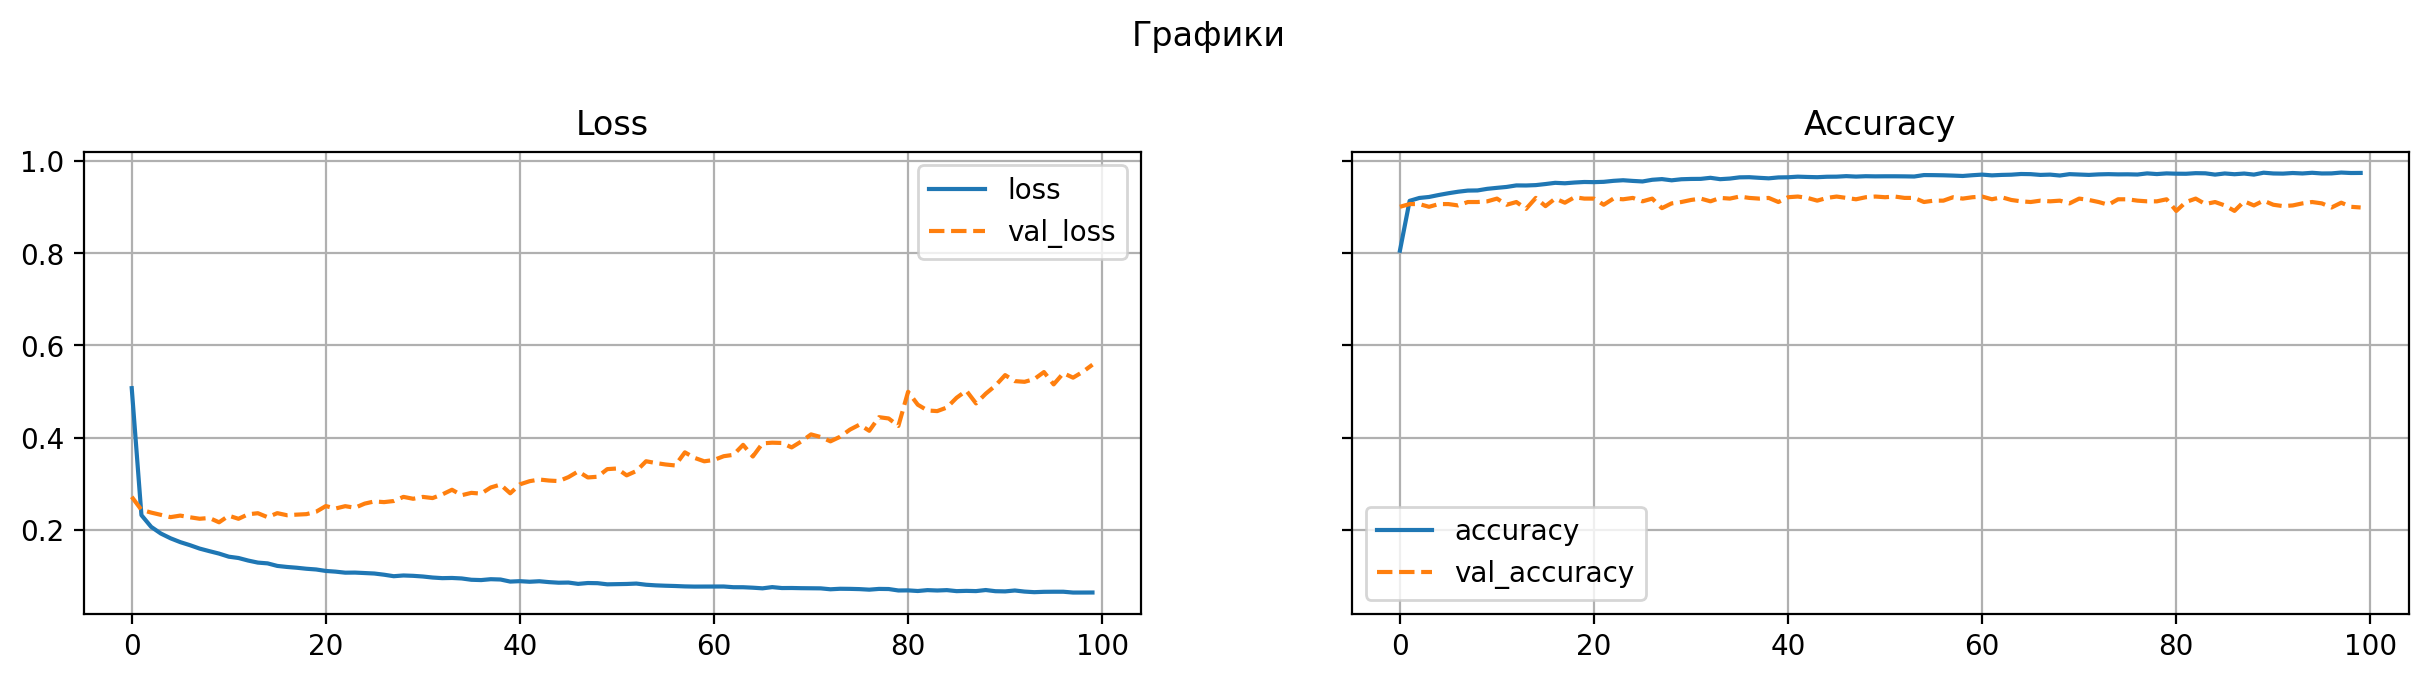

In [ ]:
visualization(history_1)

211/211 [==============================] - 1s 2ms/step
                   precision    recall  f1-score   support

            годен       0.90      0.86      0.88       600
ограниченно годен       0.85      0.96      0.90       467
         не годен       0.99      0.94      0.96       617

         accuracy                           0.91      1684
        macro avg       0.91      0.92      0.91      1684
     weighted avg       0.92      0.91      0.91      1684



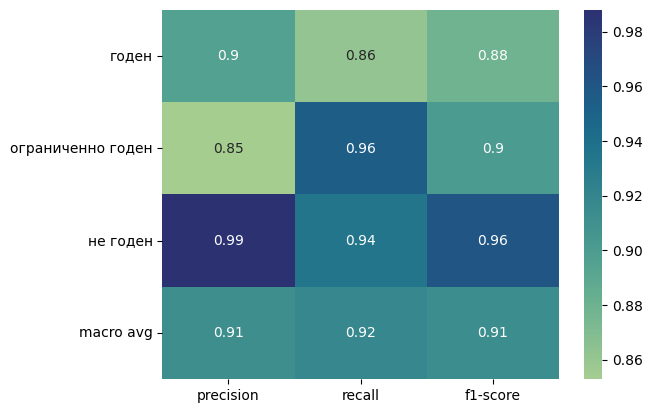

In [ ]:
class_report(model_1)


1.   Виден сильный эффект переобучения сети
2.   Высокий % распознавания позиций Негоден (они созданы искусственно, поэтому понять насколько еть распознает действительно правильно, покажет только практика)

> Выводы: необходимо принятие мер по снижению эффекта переобучения и балансировке датасета










---



### 06_2 Эксперимент №2 - 3 Dense слоя + слои нормализации BatchNormalization


> Количество нейронов оставляем аналогично предыдущей сети для дальнейшего сравнения результатов


In [ ]:
model_2 = Sequential()
model_2.add(Dense(16, activation = 'relu', input_shape=(x_train_dataset.shape[1],)))
model_2.add(BatchNormalization())
model_2.add(Dense(32, activation = 'relu'))
model_2.add(BatchNormalization())
model_2.add(Dense( 3, activation = 'softmax'))

# model_2.summary()

model_2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics='accuracy')

In [ ]:
history_2 = model_2.fit(x_train_dataset,
                        y_train_dataset,
                        batch_size=16,
                        epochs=100,
                        validation_split=0.1)

Epoch 1/100
379/379 [==============================] - 5s 7ms/step - loss: 0.3583 - accuracy: 0.8579 - val_loss: 0.4532 - val_accuracy: 0.9036
Epoch 2/100
379/379 [==============================] - 2s 6ms/step - loss: 0.2273 - accuracy: 0.9140 - val_loss: 0.2289 - val_accuracy: 0.9050
Epoch 3/100
379/379 [==============================] - 2s 6ms/step - loss: 0.2048 - accuracy: 0.9190 - val_loss: 0.2360 - val_accuracy: 0.9021
Epoch 4/100
379/379 [==============================] - 2s 5ms/step - loss: 0.1975 - accuracy: 0.9257 - val_loss: 0.2210 - val_accuracy: 0.9154
Epoch 5/100
379/379 [==============================] - 2s 6ms/step - loss: 0.1905 - accuracy: 0.9267 - val_loss: 0.2414 - val_accuracy: 0.9036
Epoch 6/100
379/379 [==============================] - 3s 9ms/step - loss: 0.1850 - accuracy: 0.9317 - val_loss: 0.2286 - val_accuracy: 0.9110
Epoch 7/100
379/379 [==============================] - 2s 6ms/step - loss: 0.1768 - accuracy: 0.9313 - val_loss: 0.2243 - val_accuracy: 0.9154

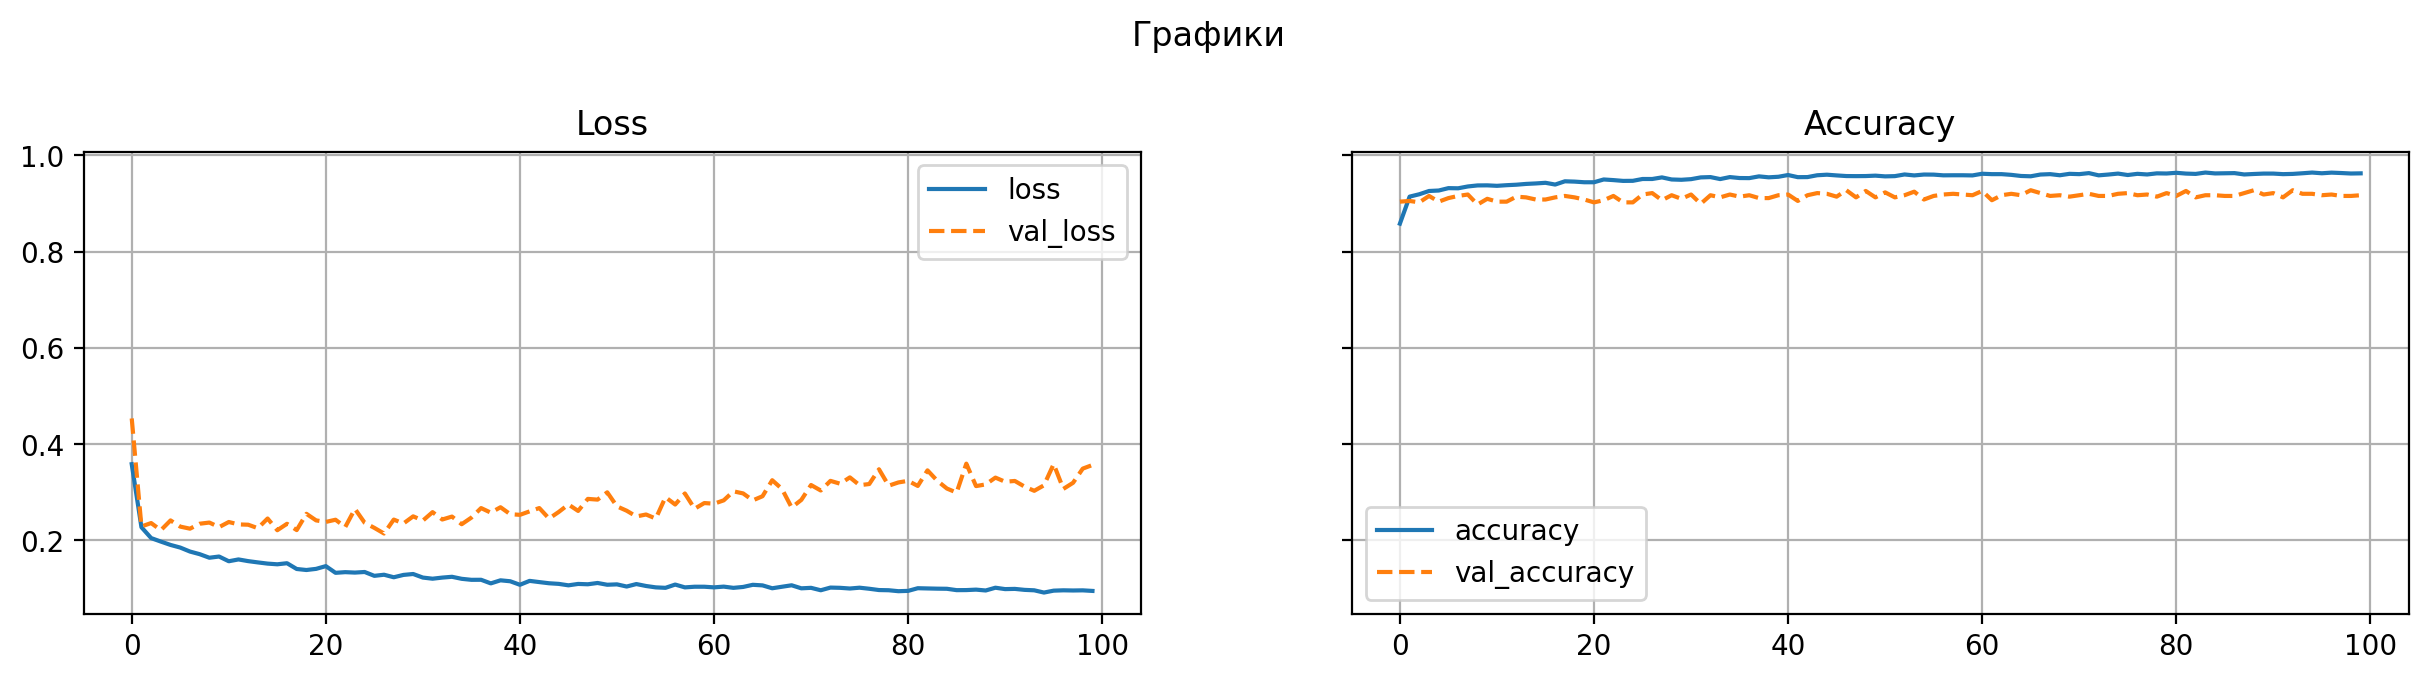

211/211 [==============================] - 0s 2ms/step
                   precision    recall  f1-score   support

            годен       0.93      0.87      0.90       600
ограниченно годен       0.86      0.91      0.88       467
         не годен       0.98      1.00      0.99       617

         accuracy                           0.93      1684
        macro avg       0.92      0.93      0.92      1684
     weighted avg       0.93      0.93      0.93      1684



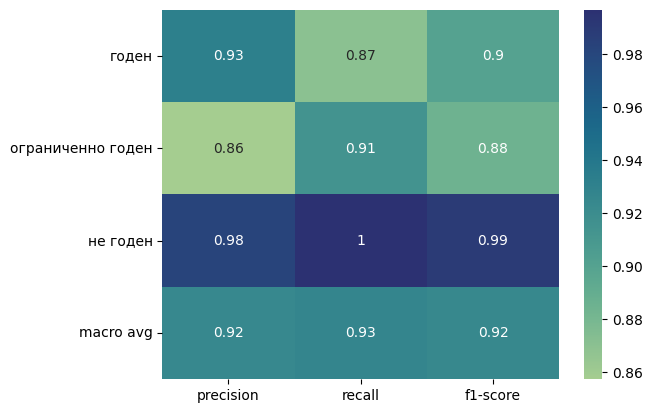

In [ ]:
visualization(history_2)
class_report(model_2)


1.   Как и в предыдущем эксперименте присутствует эффект переобучения сети, тоже достаточно сильно выражен
2.
> Выводы: слоев BatchNormalization недостаточно необходимо принятие мер по снижению эффекта переобучения и балансировке датасета




---



### 06_3 Эксперимент №3 - 3 Dense слоя + слои нормализации Dropout() + BatchNormalization()

> Количество нейронов оставляем аналогично предыдущей сети для дальнейшего сравнения результатов

In [ ]:
model_3 = Sequential()

model_3.add(Dense(16, activation = 'relu', input_shape=(x_train_dataset.shape[1],)))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.3))

model_3.add(Dense(32, activation = 'relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.3))

model_3.add(Dense( 3, activation = 'softmax'))

# model_3.summary()

model_3.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics='accuracy')

In [ ]:
history_3 = model_3.fit(x_train_dataset,
                        y_train_dataset,
                        batch_size=16,
                        epochs=100,
                        validation_split=0.1)

Epoch 1/100
379/379 [==============================] - 4s 7ms/step - loss: 0.5243 - accuracy: 0.7922 - val_loss: 0.4573 - val_accuracy: 0.8991
Epoch 2/100
379/379 [==============================] - 2s 6ms/step - loss: 0.3320 - accuracy: 0.8729 - val_loss: 0.2561 - val_accuracy: 0.9050
Epoch 3/100
379/379 [==============================] - 4s 9ms/step - loss: 0.2937 - accuracy: 0.8848 - val_loss: 0.2524 - val_accuracy: 0.9021
Epoch 4/100
379/379 [==============================] - 3s 7ms/step - loss: 0.2671 - accuracy: 0.8985 - val_loss: 0.2386 - val_accuracy: 0.9036
Epoch 5/100
379/379 [==============================] - 2s 6ms/step - loss: 0.2506 - accuracy: 0.9069 - val_loss: 0.2287 - val_accuracy: 0.9050
Epoch 6/100
379/379 [==============================] - 2s 6ms/step - loss: 0.2473 - accuracy: 0.9109 - val_loss: 0.2468 - val_accuracy: 0.9050
Epoch 7/100
379/379 [==============================] - 2s 6ms/step - loss: 0.2537 - accuracy: 0.9064 - val_loss: 0.2259 - val_accuracy: 0.9095

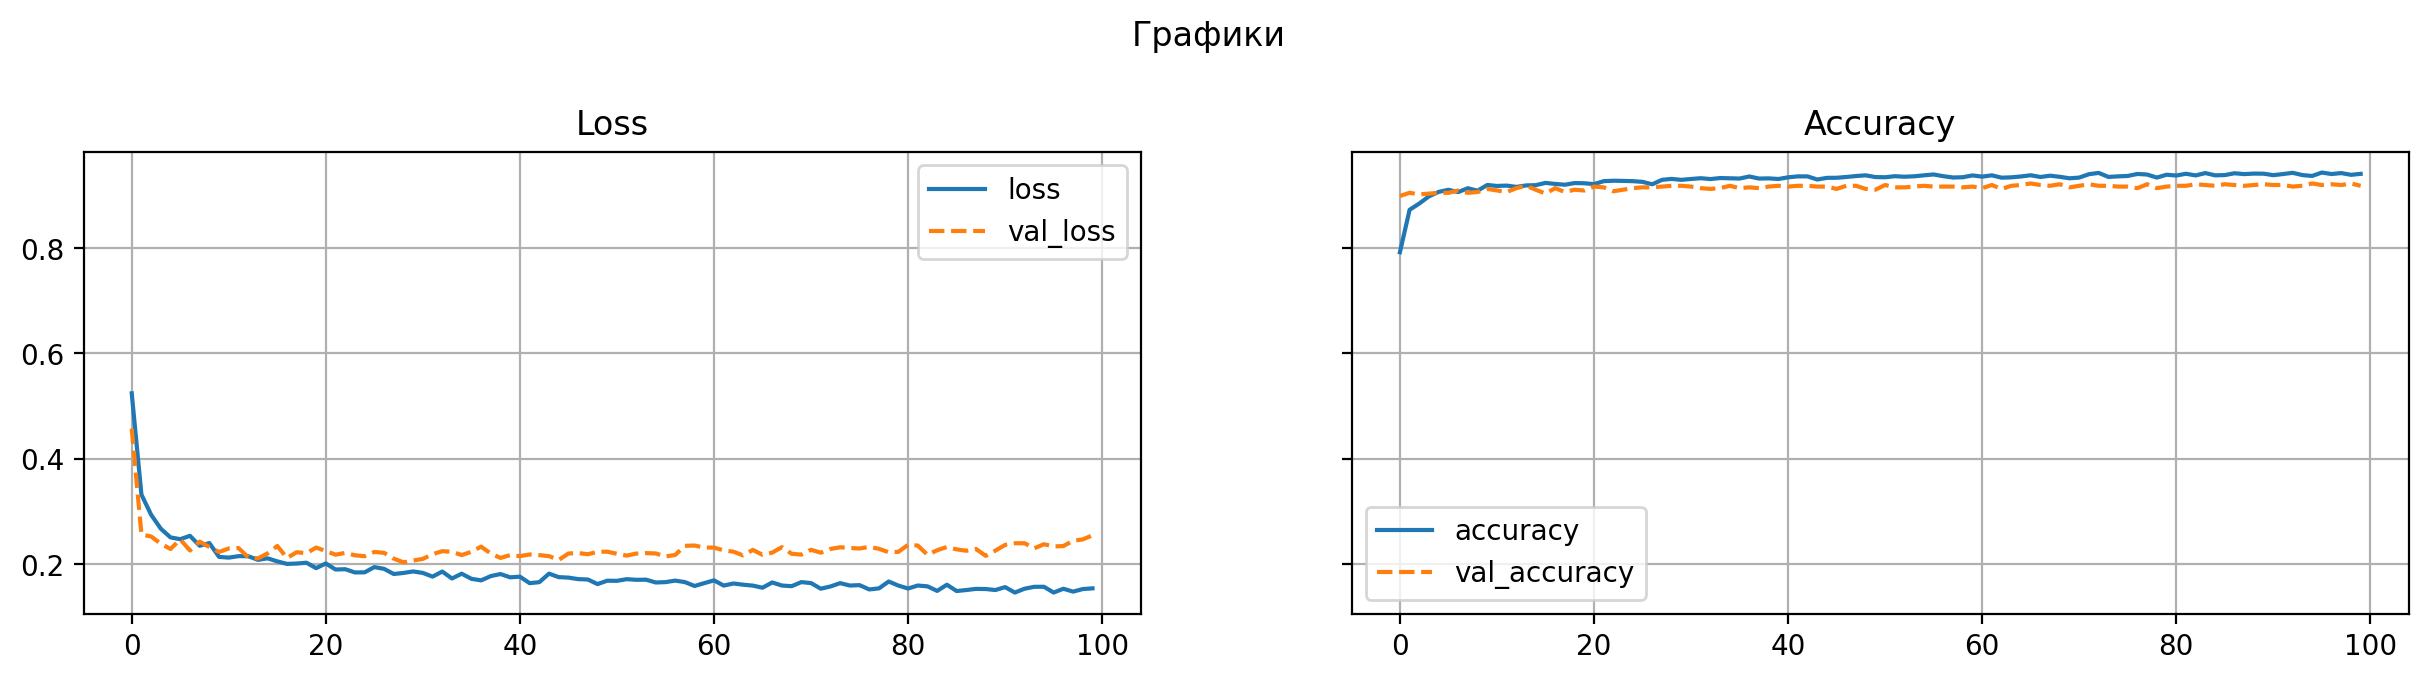

211/211 [==============================] - 0s 2ms/step
                   precision    recall  f1-score   support

            годен       0.98      0.83      0.90       600
ограниченно годен       0.83      0.99      0.90       467
         не годен       0.99      1.00      0.99       617

         accuracy                           0.94      1684
        macro avg       0.93      0.94      0.93      1684
     weighted avg       0.94      0.94      0.94      1684



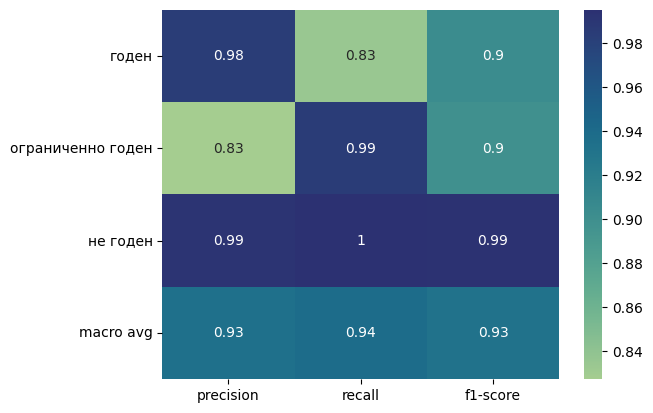

In [ ]:
visualization(history_3)
class_report(model_3)

1.   Получилось снизить эффект переобучения, но все же он присутствует
2.   немного удалось повысить точность
> Выводы: необходимо принятие дополнительных мер по балансировке датасета






---



### 06_4 Эксперимент №4 - 4(!) Dense слоя + слои нормализации Dropout() + BatchNormalization()


In [ ]:
model_4 = Sequential()
model_4.add(Dense(16, activation = 'relu', input_shape=(x_train_dataset.shape[1],)))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.3))

model_4.add(Dense(32, activation = 'relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.3))

model_4.add(Dense(64, activation = 'relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.3))

model_4.add(Dense( 3, activation = 'softmax'))

# model_4.summary()

model_4.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics='accuracy')

In [ ]:
history_4 = model_4.fit(x_train_dataset,
                        y_train_dataset,
                        batch_size=16,
                        epochs=100,
                        validation_split=0.1)

Epoch 1/100
379/379 [==============================] - 5s 9ms/step - loss: 0.5971 - accuracy: 0.7554 - val_loss: 0.4113 - val_accuracy: 0.8353
Epoch 2/100
379/379 [==============================] - 3s 9ms/step - loss: 0.3645 - accuracy: 0.8585 - val_loss: 0.2587 - val_accuracy: 0.8976
Epoch 3/100
379/379 [==============================] - 2s 6ms/step - loss: 0.3034 - accuracy: 0.8864 - val_loss: 0.2590 - val_accuracy: 0.9036
Epoch 4/100
379/379 [==============================] - 2s 6ms/step - loss: 0.2974 - accuracy: 0.8909 - val_loss: 0.2485 - val_accuracy: 0.9065
Epoch 5/100
379/379 [==============================] - 3s 7ms/step - loss: 0.2788 - accuracy: 0.8965 - val_loss: 0.2495 - val_accuracy: 0.9036
Epoch 6/100
379/379 [==============================] - 3s 7ms/step - loss: 0.2699 - accuracy: 0.8985 - val_loss: 0.2431 - val_accuracy: 0.9021
Epoch 7/100
379/379 [==============================] - 4s 9ms/step - loss: 0.2644 - accuracy: 0.9056 - val_loss: 0.2437 - val_accuracy: 0.9036

In [ ]:
# попробуем дообучить модель
model_4.compile(optimizer=Adam(learning_rate=0.00001),
                loss='categorical_crossentropy',
                metrics='accuracy')

history_4 = model_4.fit(x_train_dataset,
                        y_train_dataset,
                        batch_size=16,
                        epochs=100,
                        validation_split=0.1)

Epoch 1/100
379/379 [==============================] - 6s 11ms/step - loss: 0.1486 - accuracy: 0.9421 - val_loss: 0.2111 - val_accuracy: 0.9154
Epoch 2/100
379/379 [==============================] - 2s 7ms/step - loss: 0.1454 - accuracy: 0.9437 - val_loss: 0.2105 - val_accuracy: 0.9169
Epoch 3/100
379/379 [==============================] - 3s 7ms/step - loss: 0.1512 - accuracy: 0.9417 - val_loss: 0.2108 - val_accuracy: 0.9169
Epoch 4/100
379/379 [==============================] - 3s 7ms/step - loss: 0.1468 - accuracy: 0.9409 - val_loss: 0.2103 - val_accuracy: 0.9154
Epoch 5/100
379/379 [==============================] - 3s 8ms/step - loss: 0.1644 - accuracy: 0.9412 - val_loss: 0.2104 - val_accuracy: 0.9154
Epoch 6/100
379/379 [==============================] - 4s 10ms/step - loss: 0.1516 - accuracy: 0.9414 - val_loss: 0.2098 - val_accuracy: 0.9154
Epoch 7/100
379/379 [==============================] - 3s 7ms/step - loss: 0.1574 - accuracy: 0.9376 - val_loss: 0.2093 - val_accuracy: 0.91

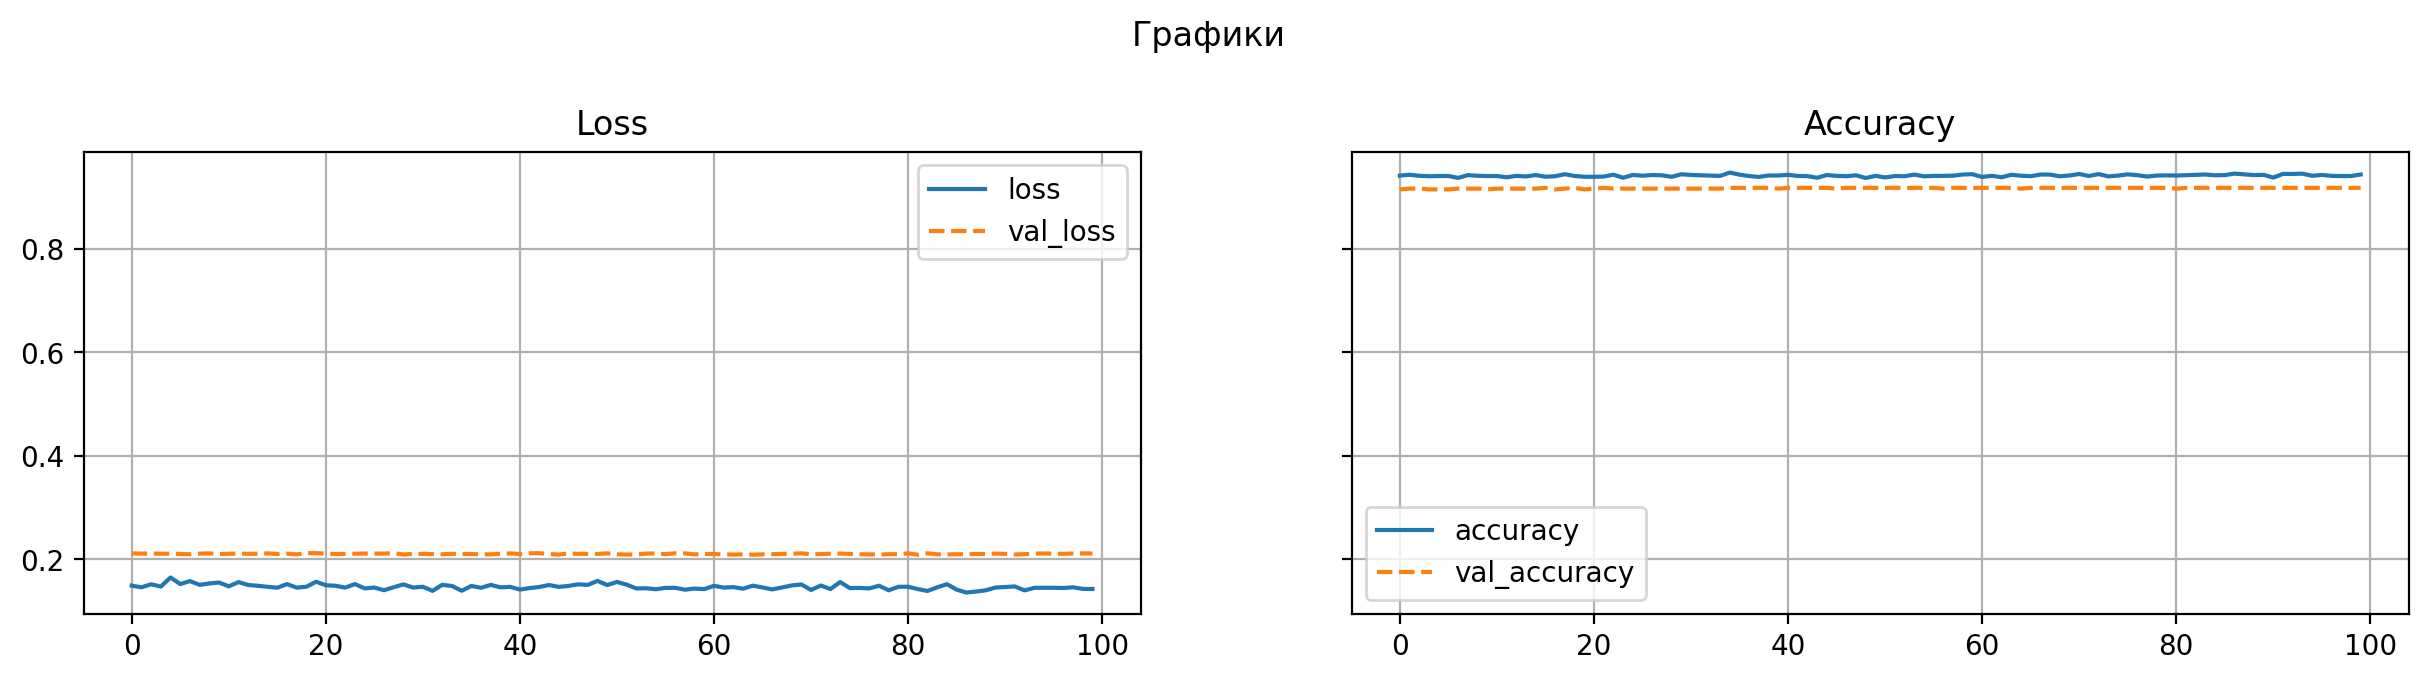

211/211 [==============================] - 0s 2ms/step
                   precision    recall  f1-score   support

            годен       0.98      0.85      0.91       600
ограниченно годен       0.84      0.98      0.91       467
         не годен       1.00      1.00      1.00       617

         accuracy                           0.94      1684
        macro avg       0.94      0.94      0.94      1684
     weighted avg       0.95      0.94      0.94      1684



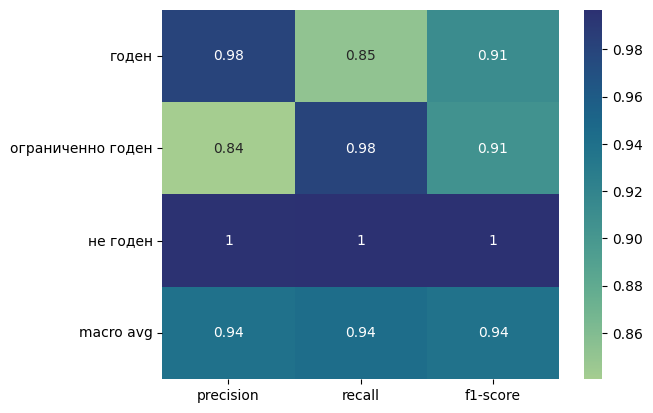

In [ ]:
visualization(history_4)
class_report(model_4)

1.   Получилось снизить эффект переобучения, но все же он присутствует
2.   Точность выше, чем в предыдущем эксперименте
> Выводы: также необходимо принятие дополнительных мер по балансировке датасета + данную архитектуру можно взять за основу для дальнейших экспериментов





---



### 06_5 Эксперимент №5 - 4(!) Dense слоя + слои нормализации Dropout() + BatchNormalization() + увеличение количества эпох и callback для изменения learning rate

In [ ]:
# определяем callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.1,
                              patience=5,
                              verbose=1,
                              mode="auto",
                              min_delta=0.00001,
                              cooldown=0,
                              min_lr=1e-10
)

In [ ]:
model_5 = Sequential()
model_5.add(Dense(32, activation = 'sigmoid', input_shape=(x_train_dataset.shape[1],)))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.5))

model_5.add(Dense(64, activation = 'sigmoid'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.5))

model_5.add(Dense(128, activation = 'sigmoid'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.5))

model_5.add(Dense(256, activation = 'sigmoid'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.5))

model_5.add(Dense(512, activation = 'sigmoid'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.5))

model_5.add(Dense( 3, activation = 'softmax'))

# model_5.summary()

model_5.compile(optimizer=Adam(learning_rate=0.00001),
                loss='categorical_crossentropy',
                metrics='accuracy')

In [ ]:
history_5 = model_5.fit(x_train_dataset,
                        y_train_dataset,
                        batch_size=64,
                        epochs=500,
                        validation_split=0.2) #,
                        # callbacks=[reduce_lr])

Epoch 1/500
85/85 [==============================] - 7s 38ms/step - loss: 1.9629 - accuracy: 0.3448 - val_loss: 1.1627 - val_accuracy: 0.3630
Epoch 2/500
85/85 [==============================] - 2s 24ms/step - loss: 1.8073 - accuracy: 0.3777 - val_loss: 1.1129 - val_accuracy: 0.3630
Epoch 3/500
85/85 [==============================] - 2s 20ms/step - loss: 1.6718 - accuracy: 0.4020 - val_loss: 1.0946 - val_accuracy: 0.3630
Epoch 4/500
85/85 [==============================] - 2s 20ms/step - loss: 1.6219 - accuracy: 0.4054 - val_loss: 1.0685 - val_accuracy: 0.4818
Epoch 5/500
85/85 [==============================] - 3s 33ms/step - loss: 1.5243 - accuracy: 0.4388 - val_loss: 0.9939 - val_accuracy: 0.7209
Epoch 6/500
85/85 [==============================] - 3s 32ms/step - loss: 1.4291 - accuracy: 0.4652 - val_loss: 0.8410 - val_accuracy: 0.7936
Epoch 7/500
85/85 [==============================] - 5s 56ms/step - loss: 1.3780 - accuracy: 0.4908 - val_loss: 0.6658 - val_accuracy: 0.8300
Epoch 

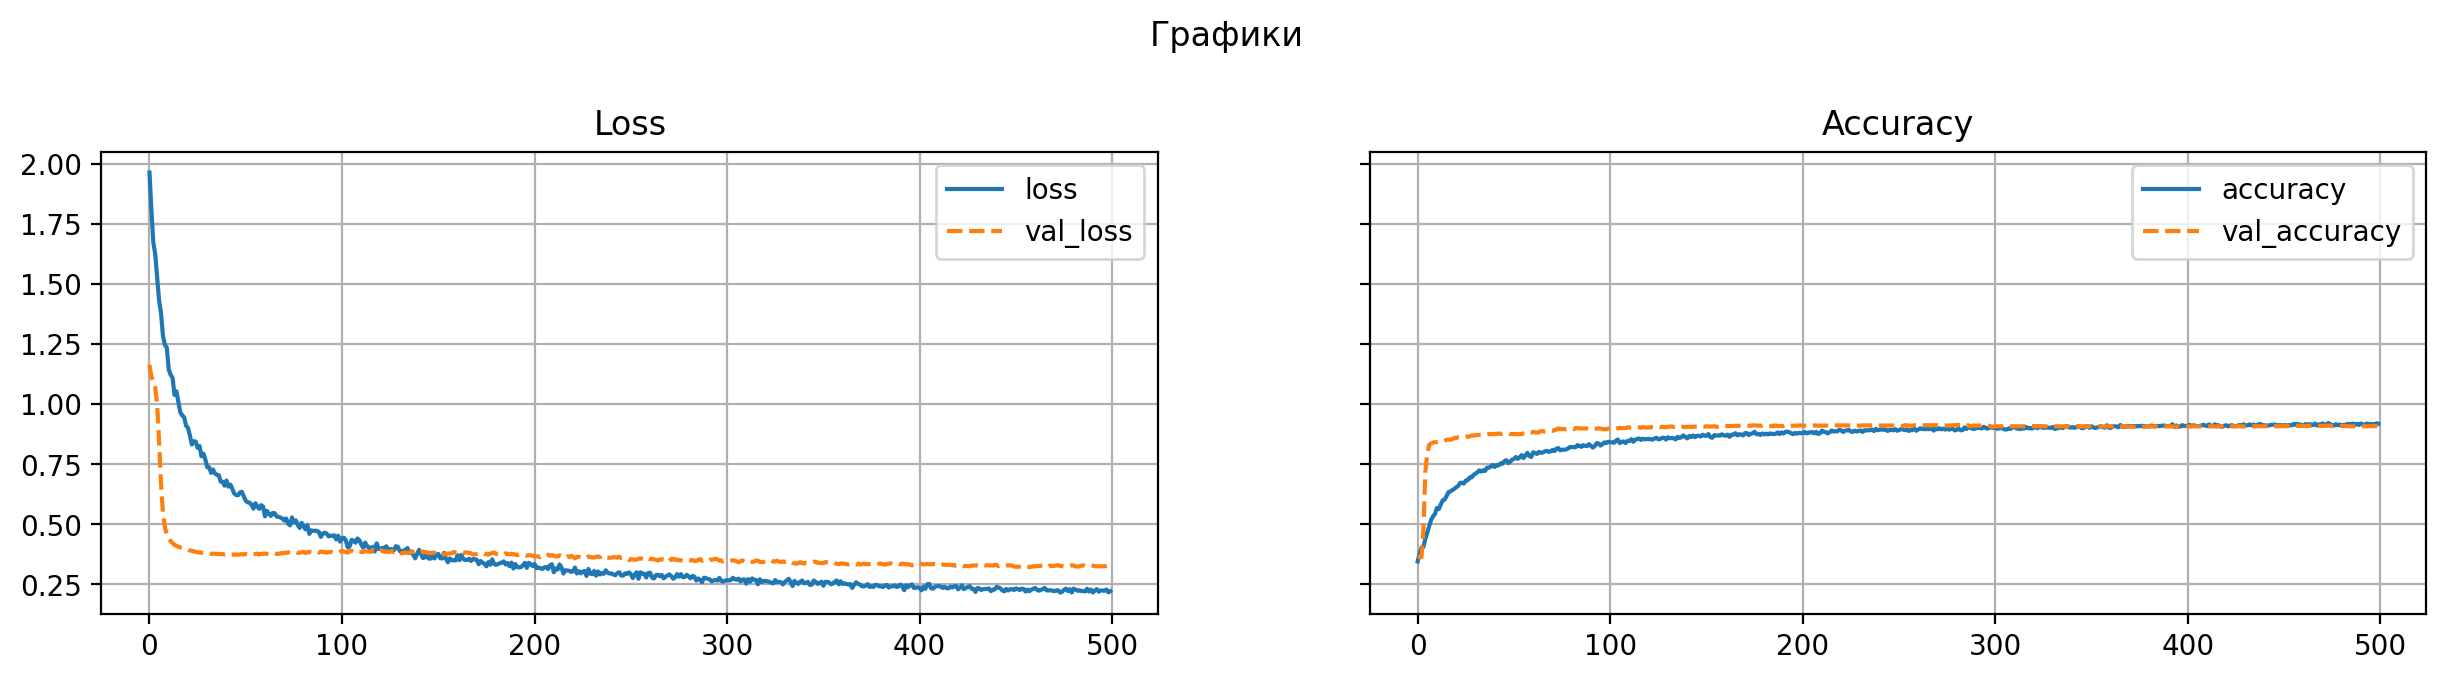

211/211 [==============================] - 1s 2ms/step
                   precision    recall  f1-score   support

            годен       0.97      0.82      0.89       600
ограниченно годен       0.81      0.97      0.88       467
         не годен       1.00      0.99      0.99       617

         accuracy                           0.93      1684
        macro avg       0.93      0.93      0.92      1684
     weighted avg       0.94      0.93      0.93      1684



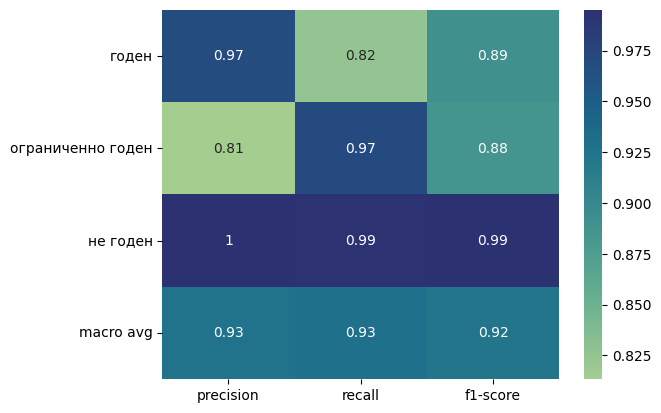

In [ ]:
visualization(history_5)
class_report(model_5)

1.   Эффекта переобучения практически не наблюдается
2.   Результаты отличаются незначительно от предыдущих экспериментов, несмотря на значительное увеличение количества эпох и снижении learning rate


> Выводы: Настоящий датасет не позволяет добиться поставленной цели. Требуется расширение и балансировка датасета с участием экспертов



### 06_6Эксперимент №6  

In [ ]:
model_6 = Sequential()
model_6.add(Dense(16, activation = 'relu', input_shape=(x_train_dataset.shape[1],)))
model_6.add(BatchNormalization())
model_6.add(Dropout(0.4))

model_6.add(Dense(32, activation = 'relu'))
model_6.add(BatchNormalization())
model_6.add(Dropout(0.4))

model_6.add(Dense(64, activation = 'relu'))
model_6.add(BatchNormalization())
model_6.add(Dropout(0.4))

model_6.add(Dense(128, activation = 'relu'))
model_6.add(BatchNormalization())
model_6.add(Dropout(0.4))

model_6.add(Dense( 3, activation = 'softmax'))

# model_6.summary()

model_6.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics='accuracy')

In [ ]:
history_6 = model_6.fit(x_train_dataset,
                        y_train_dataset,
                        batch_size=16,
                        epochs=100,
                        validation_split=0.2)

Epoch 1/100
337/337 [==============================] - 6s 9ms/step - loss: 0.9004 - accuracy: 0.6197 - val_loss: 0.8841 - val_accuracy: 0.4358
Epoch 2/100
337/337 [==============================] - 3s 8ms/step - loss: 0.5241 - accuracy: 0.7822 - val_loss: 0.3032 - val_accuracy: 0.8805
Epoch 3/100
337/337 [==============================] - 2s 7ms/step - loss: 0.4407 - accuracy: 0.8241 - val_loss: 0.2654 - val_accuracy: 0.9065
Epoch 4/100
337/337 [==============================] - 3s 8ms/step - loss: 0.3695 - accuracy: 0.8475 - val_loss: 0.2575 - val_accuracy: 0.9057
Epoch 5/100
337/337 [==============================] - 4s 11ms/step - loss: 0.3438 - accuracy: 0.8696 - val_loss: 0.2658 - val_accuracy: 0.9020
Epoch 6/100
337/337 [==============================] - 3s 8ms/step - loss: 0.3111 - accuracy: 0.8808 - val_loss: 0.2574 - val_accuracy: 0.9050
Epoch 7/100
337/337 [==============================] - 3s 8ms/step - loss: 0.3192 - accuracy: 0.8815 - val_loss: 0.2586 - val_accuracy: 0.902

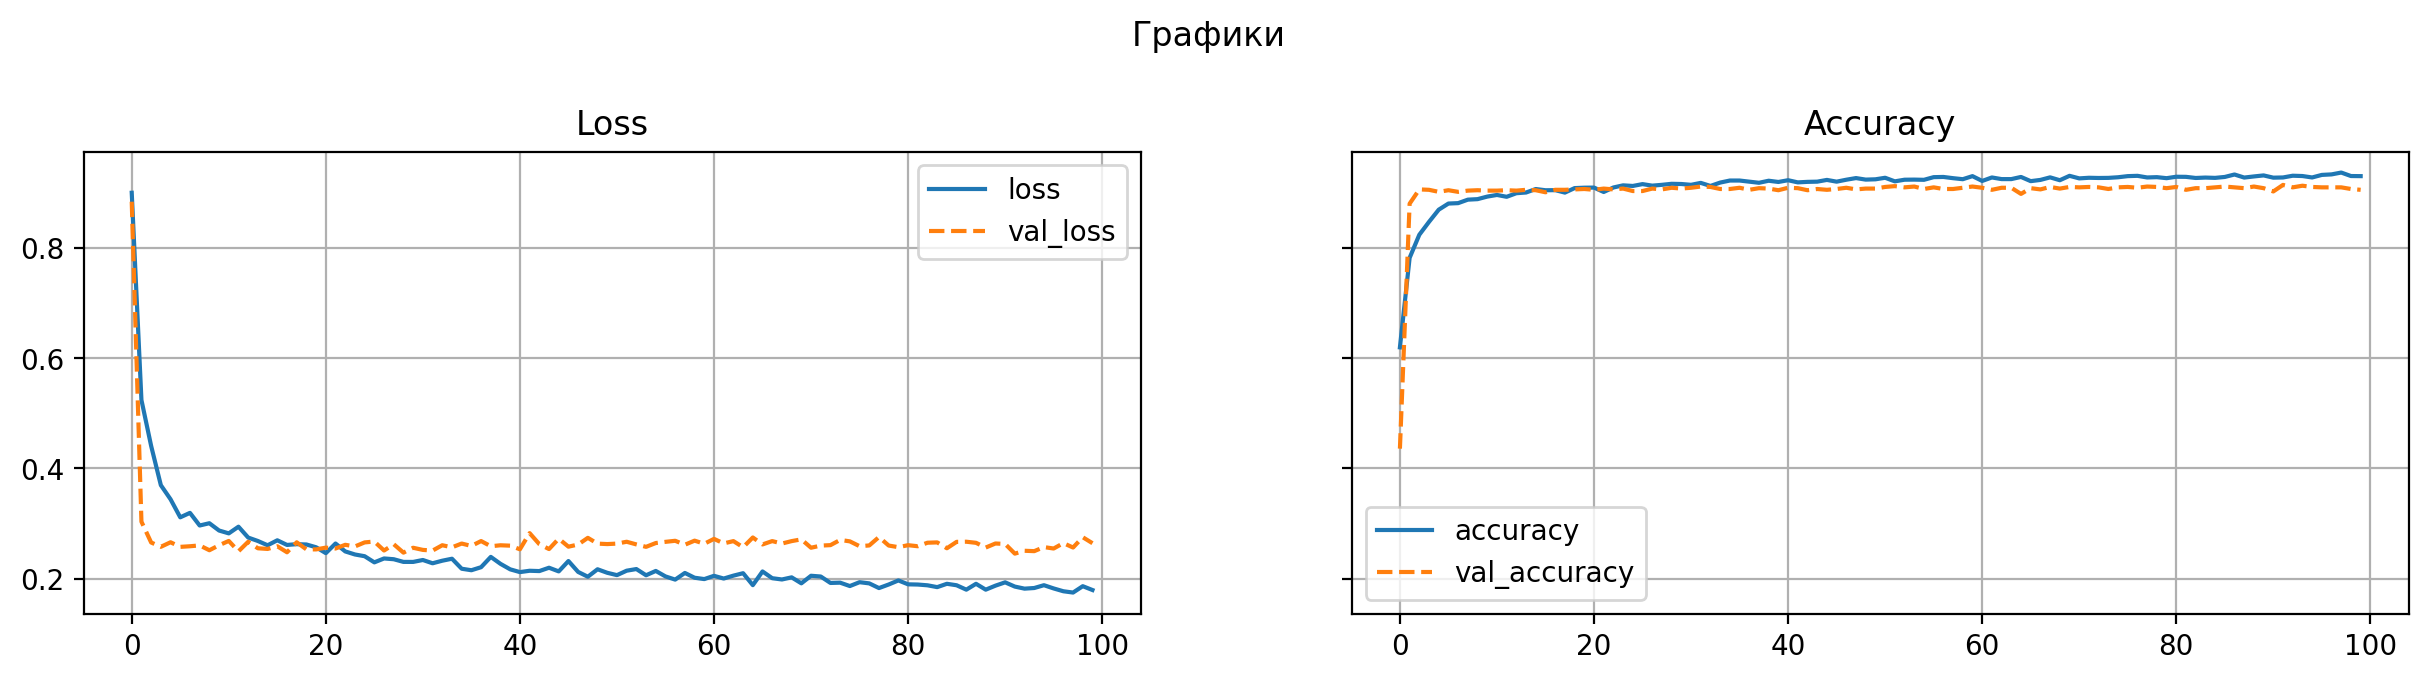

211/211 [==============================] - 1s 2ms/step
                   precision    recall  f1-score   support

            годен       0.98      0.82      0.89       600
ограниченно годен       0.81      0.98      0.89       467
         не годен       0.99      0.99      0.99       617

         accuracy                           0.93      1684
        macro avg       0.93      0.93      0.93      1684
     weighted avg       0.94      0.93      0.93      1684



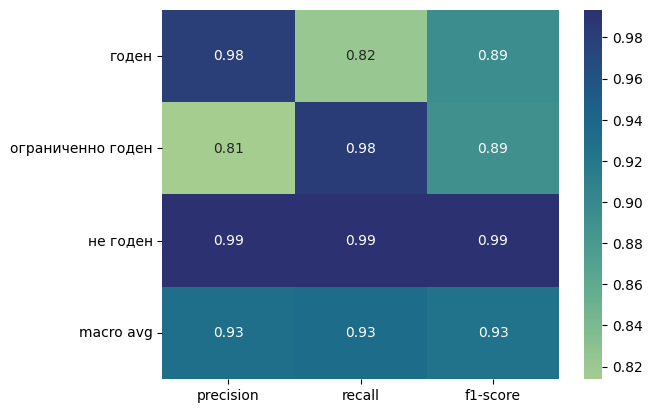

In [ ]:
visualization(history_6)
class_report(model_6)



---



# 07 Вывод предсказаний сети и рекомендаций
> работаем с первоначальным датасетом без корректировок (как был выгружен заказчиком)



## Функции

In [ ]:
#@title Функция выбора столбцов с МКБ

def mkb_list(dataframe, position, keyword='МКБ'):
    columns_mkb = []
    mkb_list = []

    columns = dataframe.columns.tolist()

    for col_name in columns:
        if keyword in col_name:
            columns_mkb.append(col_name)

    for column in columns_mkb:
        mkb = dataframe[column][position]
        mkb_list.append(str(mkb))
        try:
            mkb_list.remove('nan') # убираем из значений nan
        except:
            pass

        mkb_list = list(set(mkb_list))

    return mkb_list, columns_mkb

In [ ]:
#@title Функция составления всех возможных пар МКБ-ВредныйФактор для позиции

def get_pairs(mkb_list=mkb_list , hfactors=hfactors):
    pairs_lst =[]
    for i, mkb in enumerate(mkb_list):
        for j, factor in enumerate(hfactors):
            pairs_lst.append((mkb, factor))
    return pairs_lst

In [ ]:
#@title  Функция для определения возраста
def age_calc(birth_date, checkup_date, position):
    birth = datetime.strptime((re.split('T', dataframe[birth_date][position])[0]),"%Y-%m-%d")
    checkup = datetime.strptime((re.split('T', dataframe[checkup_date][position])[0]),"%Y-%m-%d")
    age = (checkup-birth).days // 365
    # print()
    # print('birth', birth)
    # print('checkup', checkup)
    # print('age', age)
    return age

In [ ]:
#@title Функция представление рекомендаций (нейросеть + сопоставление с приказом 29н)

gender_column = 'КлиентПолПредставление'
hfactor_column = 'ВредныеФакторы'
profession_column = 'Профессия'
department_col = 'Цех'
dataframe = df
position = 19714
model=model_1
birth_date = 'КлиентДатаРождения'
checkup_date = 'ДатаЗавершенияМедосмотра'




def recomendation(dataframe,
                  position,
                  model,
                  gender_column=gender_column,
                  hfactor_column=hfactor_column,
                  profession_column=profession_column,
                  department_col=department_col,
                  birth_date=birth_date,
                  checkup_date=checkup_date,
                  keywords_mkb='МКБ'):

    mkb, columns_mkb = mkb_list(dataframe, position) # формирование списка с МКБ

    gender = [dataframe[gender_column][position]]
    age = age_calc(birth_date, checkup_date, position)
    profession = dataframe[profession_column][position]
    department = dataframe[department_col][position]

    print('Пол: ', gender)
    print('Цех: ', department)
    print('Профессия: ', profession)
    print('Возраст: ', age)

    print('-------------------------------------------------------------------------------')

    # расчет вредных факторов для пациента
    hfactors = hfactor_corr(dataframe[hfactor_column][position])
    hfactors = re.split(',', hfactors)
    print('Вредные факторы:', hfactors)

    for h in hfactors:
        hfactor_class = df_factors['Класс вредных факторов'][df_factors['Вредный фактор_код']== h].values[0]
        hfactor_definition = df_factors['Наименование вредных и (или) опасных производственных факторов'][df_factors['Вредный фактор_код']== h].values[0]

        # print(h, 'Класс:', hfactor_class,'Описание:', hfactor_definition )
        print('%-7s %-4s %-7s %-1s %-7s' % (h, 'Класс', hfactor_class,':', hfactor_definition ))
    print('-------------------------------------------------------------------------------')

    # вывод мкб диагнозов для пациента
    if mkb:
        print('Диагнозы МКБ:')
        for m in mkb:
            mkb_definition = df_mkb_catalog['mkb_name'][df_mkb_catalog['mkb_cod'] == m].values[0]
            print('%-7s %-4s' % (m, mkb_definition))


        x_raw = gender + hfactors + mkb
        x_bow = tokenization_x(x_raw).reshape(1,13175)

        y_pred = model.predict(x_bow, verbose=0)
        # y_pred_bool = np.argmax(y_pred, axis=1)
        conclusion = categories[int(np.argmax(y_pred, axis=1))]
        print('-------------------------------------------------------------------------------')
        print('Предварительное заключение:', conclusion, 'c вероятностью:', round((y_pred.max()*100),2), '%')
        print('Заключение в датасете:', dataframe['ЗаключениеМК'][position])
        print('-------------------------------------------------------------------------------')

        pairs = get_pairs(mkb,hfactors)
        # print('pairs', pairs)

        list_explanation =[]
        for i, pair in enumerate(pairs):
            for j, prikaz_lst in enumerate(df_29n['pairs_lst']):
                if prikaz_lst.count(pair) == 1:

                    print('\n\nВнимание! для пары', pair, ' есть запись в приложении №2 Приказа 29н')
                    print('---')
                    print('%-10s %-4s' % ('МКБ:', pair[0]))
                    print('%-10s %-4s' % ('Вредность:', pair[1]))
                    print('---')
                    print('№', df_29n.iloc[j].values[0],':',df_29n.iloc[j].values[1:3] )

                    if (df_29n.iloc[j].values[7]) == np.nan:
                        print('Примечания', df_29n.iloc[j].values[7])
    else:
        print('Диагноз не определен')



## Примеры рекомендаций

In [ ]:
recomendation(df, 8, model_5)

Пол:  ['Мужской']
Цех:  МНУ-1
Профессия:  Мастер
Возраст:  31
-------------------------------------------------------------------------------
Вредные факторы: ['9', '26']
9       Класс VI. Выполняемые работы : Работы, связанные с техническим обслуживанием электроустановок напряжением 50 В и выше переменного тока и 75 В и выше постоянного тока, проведением в них оперативных переключений, выполнением строительных, монтажных, наладочных, ремонтных работ, испытанием и измерением
26      Класс VI. Выполняемые работы : Работы в организациях, деятельность которых связана с коммунальным и бытовым обслуживанием населения
-------------------------------------------------------------------------------
Диагнозы МКБ:
H52.1   Миопия
Z00.0   Общий медицинский осмотр
-------------------------------------------------------------------------------
Предварительное заключение: ограниченно годен c вероятностью: 85.01 %
Заключение в датасете: Годен
-----------------------------------------------------------

In [ ]:
recomendation(df, 2360, model_5)

Пол:  ['Мужской']
Цех:  nan
Профессия:  nan
Возраст:  40
-------------------------------------------------------------------------------
Вредные факторы: ['4.3.1', '4.3.2', '4.4', '18.1']
4.3.1   Класс IV. Физические факторы : Локальная вибрация
4.3.2   Класс IV. Физические факторы : Общая вибрация (транспортная, транспортно-технологическая, технологическая)
4.4     Класс IV. Физические факторы : Шум    
18.1    Класс VI. Выполняемые работы : Управление наземными транспортными средствами категории "A", "B", "BE", трактора и другие самоходные машины, мини-трактора, мотоблоки, автопогрузчики, электрокары, регулировщики и т.п., автомобили всех категорий с ручным управлением для инвалидов, мотоколяски для инвалидов
-------------------------------------------------------------------------------
Диагноз не определен


In [ ]:
recomendation(df, 21234, model_5)

Пол:  ['Женский']
Цех:  nan
Профессия:  Кассир
Возраст:  29
-------------------------------------------------------------------------------
Вредные факторы: ['23']
23      Класс VI. Выполняемые работы : Работы, где имеется контакт с пищевыми продуктами в процессе их производства, хранения, транспортировки и реализации (в организациях пищевых и перерабатывающих отраслей промышленности, сельского хозяйства, пунктах, базах, складах хранения и реализации, в транспортных организациях, организациях торговли, общественного питания, на пищеблоках всех учреждений и организаций)
-------------------------------------------------------------------------------
Диагнозы МКБ:
Z00.0   Общий медицинский осмотр
N60.2   Фиброаденоз молочной железы
-------------------------------------------------------------------------------
Предварительное заключение: годен c вероятностью: 99.71 %
Заключение в датасете: nan
-------------------------------------------------------------------------------


In [ ]:
recomendation(df, 13987, model_5)

Пол:  ['Женский']
Цех:  Кухня
Профессия:  Официант
Возраст:  19
-------------------------------------------------------------------------------
Вредные факторы: ['23']
23      Класс VI. Выполняемые работы : Работы, где имеется контакт с пищевыми продуктами в процессе их производства, хранения, транспортировки и реализации (в организациях пищевых и перерабатывающих отраслей промышленности, сельского хозяйства, пунктах, базах, складах хранения и реализации, в транспортных организациях, организациях торговли, общественного питания, на пищеблоках всех учреждений и организаций)
-------------------------------------------------------------------------------
Диагнозы МКБ:
Z00.0   Общий медицинский осмотр
-------------------------------------------------------------------------------
Предварительное заключение: годен c вероятностью: 99.75 %
Заключение в датасете: Годен
-------------------------------------------------------------------------------


In [ ]:
recomendation(df, 1468, model_5)

Пол:  ['Мужской']
Цех:  nan
Профессия:  nan
Возраст:  24
-------------------------------------------------------------------------------
Вредные факторы: ['27']
27      Класс VI. Выполняемые работы : Работы в медицинских организациях
-------------------------------------------------------------------------------
Диагнозы МКБ:
Z00.0   Общий медицинский осмотр
-------------------------------------------------------------------------------
Предварительное заключение: годен c вероятностью: 99.75 %
Заключение в датасете: nan
-------------------------------------------------------------------------------


In [ ]:
recomendation(df, 13689, model_5)

Пол:  ['Мужской']
Цех:  nan
Профессия:  Грузчик
Возраст:  35
-------------------------------------------------------------------------------
Вредные факторы: ['5.1', '11.3', '23', '26']
5.1     Класс V. Факторы трудового процесса : Тяжесть трудового процесса Подъем, перемещение, удержание груза вручную Стереотипные рабочие движения
Рабочее положение тела работника (длительное нахождение работника в положении "стоя", "сидя" без перерывов, "лежа", "на коленях", "на корточках", с наклоном или поворотом туловища, с поднятыми выше уровня плеч руками, с неудобным размещением ног, с невозможностью изменения взаимного положения различных частей тела относительно друг друга, длительное перемещение работника в пространстве) Работы, связанные с постоянной ходьбой и работой стоя в течение всего рабочего дня
11.3    Класс VI. Выполняемые работы : Работы, не указанные в подпунктах 11.1 (Работы в нефтяной и газовой промышленности, выполняемые в районах Крайнего Севера и приравненных к ним местностях,

In [ ]:
recomendation(df, 13678, model_5)

Пол:  ['Мужской']
Цех:  nan
Профессия:  Водитель погрузчика
Возраст:  21
-------------------------------------------------------------------------------
Вредные факторы: ['18.1', '26']
18.1    Класс VI. Выполняемые работы : Управление наземными транспортными средствами категории "A", "B", "BE", трактора и другие самоходные машины, мини-трактора, мотоблоки, автопогрузчики, электрокары, регулировщики и т.п., автомобили всех категорий с ручным управлением для инвалидов, мотоколяски для инвалидов
26      Класс VI. Выполняемые работы : Работы в организациях, деятельность которых связана с коммунальным и бытовым обслуживанием населения
-------------------------------------------------------------------------------
Диагнозы МКБ:
Z00.0   Общий медицинский осмотр
-------------------------------------------------------------------------------
Предварительное заключение: годен c вероятностью: 99.84 %
Заключение в датасете: Годен
--------------------------------------------------------------------

### Посмотрим как нейросеть определит позиции Негоден

In [ ]:
list(df[df['ЗаключениеМК'] == 'Негоден'].index)

[21576, 27489, 30022]

In [ ]:
recomendation(df, 21576, model_4) # здесь как раз лучше сработала модель с архитектурой №4

Пол:  ['Мужской']
Цех:  Отдел технологии литья
Профессия:  Оператор станков с ЧПУ
Возраст:  19
-------------------------------------------------------------------------------
Вредные факторы: ['4.2.5', '15']
4.2.5   Класс IV. Физические факторы : Электромагнитное поле широкополосного спектра частот (5 Гц - 2 кГц, 2 кГц - 400 кГц)
15      Класс VI. Выполняемые работы : Работы, выполняемые непосредственно на механическом оборудовании, имеющем открытые движущиеся (вращающиеся) элементы конструкции, в случае если конструкцией оборудования не предусмотрена защита (ограждение) этих элементов (в том числе токарные, фрезерные и другие станки, штамповочные прессы)
-------------------------------------------------------------------------------
Диагнозы МКБ:
H90.3   Нейросенсорная потеря слуха двусторонняя
H52.2   Астигматизм
Z00.0   Общий медицинский осмотр
H66.2   Хронический эпитимпано-антральный гнойный средний отит
-----------------------------------------------------------------------------

In [ ]:
recomendation(df, 27489, model_5)

Пол:  ['Мужской']
Цех:  Без отдела
Профессия:  Машинист автокрана
Возраст:  59
-------------------------------------------------------------------------------
Вредные факторы: ['4.3.1', '4.3.2', '4.4', '5.2', '8', '18.2']
4.3.1   Класс IV. Физические факторы : Локальная вибрация
4.3.2   Класс IV. Физические факторы : Общая вибрация (транспортная, транспортно-технологическая, технологическая)
4.4     Класс IV. Физические факторы : Шум    
5.2     Класс V. Факторы трудового процесса : Напряженность трудового процесса (сенсорные нагрузки)
8       Класс VI. Выполняемые работы : Работы в качестве крановщика (машиниста крана, машинист крана автомобильного)
18.2    Класс VI. Выполняемые работы : Управление наземными транспортными средствами категории "C", "C1", "CE", "D1", "D1E", трамвай, троллейбус
-------------------------------------------------------------------------------
Диагнозы МКБ:
I11.9   Гипертензивная [гипертонич.] бол.с преимущ.пораж.сердца без сердечн.недост.
B35.6   Эпидермофи

In [ ]:
recomendation(df, 30022, model_5)

Пол:  ['Мужской']
Цех:  Без отдела
Профессия:  Машинист автокрана
Возраст:  59
-------------------------------------------------------------------------------
Вредные факторы: ['4.3.1', '4.3.2', '4.4', '5.2', '8', '18.2']
4.3.1   Класс IV. Физические факторы : Локальная вибрация
4.3.2   Класс IV. Физические факторы : Общая вибрация (транспортная, транспортно-технологическая, технологическая)
4.4     Класс IV. Физические факторы : Шум    
5.2     Класс V. Факторы трудового процесса : Напряженность трудового процесса (сенсорные нагрузки)
8       Класс VI. Выполняемые работы : Работы в качестве крановщика (машиниста крана, машинист крана автомобильного)
18.2    Класс VI. Выполняемые работы : Управление наземными транспортными средствами категории "C", "C1", "CE", "D1", "D1E", трамвай, троллейбус
-------------------------------------------------------------------------------
Диагнозы МКБ:
I11.9   Гипертензивная [гипертонич.] бол.с преимущ.пораж.сердца без сердечн.недост.
B35.6   Эпидермофи

# Общие выводы по проекту

Разбалансированный датасет не позволяет эффективно и корректно настроить нейросеть.

Рекомендации по подготовке датасета:

1. Сложно было работать с дтасетом, где очень много задвоенных данных. Причем данные, которые по логике, должны быть одинаковы могут отличаться. Учитывая данный момент


> Рекомендация 1: совместно с профпатологом, либо на основании к-л методических рекомендаций составить схему данных, которые влияют на принятие решений и сформировать выгрузку только релевантных значений, это значительно сократит время обработки датасета.


2. Данные не сбалансированы. Слишком мало данных для обучения нейросети и по результатам видно, что нейросеть достаточно успешно выделят признак "годен", но насколько она это делает следуя алгоритму (а не просто угадывая) на текущих данных не определить.


> Рекомендация 2: провести балансировку датасета. Возможно следует искуственно расширить данные (для несуществующих пациентов), но расширение датасета следует проводить с консультациями экспертов (врача профпатолога или профильных специалистов)

3. Скорректировать представление в датасете категориальных данных - часто наблюдалось, что категориальные данные либо разделены на несколько колонок, либо вводятся не из справочника, либо друг друга дублируют, либо друг другу противоречат.
Например я бы добавила ряд категориальных данных из заключений профильных специалистов, для проверки гипотезы по их влиянию на результат, но при такой разбалансировке очень сложно будет оценить их влияние.


